In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
import statsmodels.stats.multitest as mt

#%load_ext iversions
#%iversions

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(6,4), 'font.size':14}
sns.set_theme(style="ticks", rc=custom_params, font='Arial') 
custom_palette = [sns.color_palette(["#117733"])[0]] + [sns.color_palette(["#882255"])[0]] + sns.light_palette("#DDCC77", 6)[1:] + sns.light_palette("#CC6677", 9)[1:] + sns.light_palette("#88CCEE", 5)[1:]

cmap = sns.color_palette("blend:#88CCEE,#FFFFFF,#CC6677", as_cmap=True)
cmap.set_bad(sns.color_palette("dark:#D3D3D3", 2)[1])

nleaves = 2
npunches = 4

In [3]:
#Input xlsx file generated from a BioTek Synergy H1 microplate reader.
#Wells are assumed to be filled by row, left to right. Discs are added by plant, leaf T4 first and then leaf T5.
#Ex. Discs from plant 1 leaf T4, plant 1 leaf T5, plant 2 leaf T4, etc.
#read_plate_data does NOT add condition information to DataFrame. 
def read_plate_data(filename, date, condsperplate):
    #Make empty DataFrame using the loaded Excel file's headers.
    df = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=0)
    
    #Iterate through all the sheets of the Excel file and populate the DataFrame.
    for i in range(0, (nconds//condsperplate)):
        temp = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=nplants*nleaves*npunches*condsperplate, sheet_name=i)
        df = pd.concat([df, temp])

    #Special treatment for partially-filled plates.
    if nconds%condsperplate != 0:
        temp = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=nplants*nleaves*npunches*(nconds%condsperplate), sheet_name=nconds//condsperplate)
        df = pd.concat([df, temp])
    
    #Add unique plant ID #.
    plantid_list = []
    for i in np.arange(1, nplants+1):
        plantid_list = plantid_list + [i]*nleaves*npunches
    df['Plant'] = plantid_list*nconds
    
    #Add leaf T4/T5 information.
    df['Leaf'] = ((['T4']*npunches + ['T5']*npunches)*nplants)*nconds
    
    #Rename the fluorescence wavelengths as corresponding colors. Convert to float64.
    df = df.rename(columns={488520: 'eGFP', 587615: 'mCherry'})
    df['eGFP'] = (df['eGFP']).astype('float64')
    df['mCherry'] = (df['mCherry']).astype('float64')
    
    #Add date of punching--these are also unique experiment IDs.
    df['Date'] = [date]*nconds*nplants*nleaves*npunches

    #Add log2(eGFP) and log2(mCherry) columns.
    df['log2green'] = np.log2(df['eGFP'])
    df['log2red'] = np.log2(df['mCherry'])

    #Calculate ratios of red and green.
    df['eGFP/mCherry'] = (df['eGFP']/df['mCherry']).astype('float64')
    df['mCherry/eGFP'] = (df['mCherry']/df['eGFP']).astype('float64')

    return df.reset_index(drop=True)

In [4]:
#Input a DataFrame generated by read_plate_data.
def calc_cv(df):
    #Make empty DataFrame to contain the coefficient of variance (standard deviation/mean) for fluorescence 
    #and fluorescence ratios.
    cv = pd.DataFrame(data={'eGFP CV': [], 'mCherry CV': [], 'eGFP/mCherry CV': [], 'mCherry/eGFP CV': []})
    
    #Iterate through the conditions tested and calculate the CVs.
    for cond in conds:
        cond_df = df[df['Condition'] == cond]
        
        g_cv = np.std(cond_df['eGFP']) / np.mean(cond_df['eGFP'])
        r_cv = np.std(cond_df['mCherry']) / np.mean(cond_df['mCherry'])
        gr_cv = np.std(cond_df['eGFP/mCherry']) / np.mean(cond_df['eGFP/mCherry'])
        rg_cv = np.std(cond_df['mCherry/eGFP']) / np.mean(cond_df['mCherry/eGFP'])
        
        temp = pd.DataFrame(data={'eGFP CV': [g_cv], 'mCherry CV': [r_cv], 'eGFP/mCherry CV': [gr_cv], 'mCherry/eGFP CV': [rg_cv]})
        cv = pd.concat([cv, temp])
    
    cv = cv.reset_index(drop=True)
    cv['Condition'] = conds

    #Convert to float64.
    for col in ['eGFP CV', 'mCherry CV', 'eGFP/mCherry CV', 'mCherry/eGFP CV']:
        cv[col] = cv[col].to_numpy(dtype=np.float64)
    
    return cv

In [5]:
#Input a DataFrame generated by read_plate_data. Does not replace meaningless values with np.NaN.
def calc_cv_by_plant(df):
    condlist = []
    datelist = []
    plantlist = []
    glist = []
    rlist = []
    grlist = []
    rglist = []
    
    for date in list(df.Date.unique()):
        date_df = df[df.Date == date]
        datelist = datelist + [date]*nconds*nplants
        
        for cond in conds:
            cond_date_df = date_df[date_df.Condition == cond]
        
            for plant in list(range(1, nplants+1)):
                condlist = condlist + [cond]
                plantlist = plantlist + [list(df.Date.unique()).index(date)*nplants+plant]
                glist = glist + [np.std(cond_date_df[cond_date_df.Plant == plant].eGFP) / np.average(cond_date_df[cond_date_df.Plant == plant].eGFP)]
                rlist = rlist + [np.std(cond_date_df[cond_date_df.Plant == plant].mCherry) / np.average(cond_date_df[cond_date_df.Plant == plant].mCherry)]
                grlist = grlist + [np.std(cond_date_df[cond_date_df.Plant == plant]['eGFP/mCherry']) / np.average(cond_date_df[cond_date_df.Plant == plant]['eGFP/mCherry'])]
                rglist = rglist + [np.std(cond_date_df[cond_date_df.Plant == plant]['mCherry/eGFP']) / np.average(cond_date_df[cond_date_df.Plant == plant]['mCherry/eGFP'])]
    
    return pd.DataFrame(data={'Condition': condlist, 'Date': datelist, 'Plant': plantlist, 'eGFP CV': glist, 'mCherry CV': rlist, 'eGFP/mCherry CV': grlist, 'mCherry/eGFP CV': rglist})

In [6]:
#Input DataFrame from calc_cv_by_plant.
def melt_cv(cv_by_plant, green_only, red_only):
    #Store index of green control, red control, and all conditions from the cv_by_plant DataFrame. 
    green_index = cv_by_plant[cv_by_plant.Condition == green_only]['eGFP CV'].index
    red_index = cv_by_plant[cv_by_plant.Condition == red_only]['mCherry CV'].index
    cond_index = list(set(cv_by_plant.index) ^ set(list(green_index) + list(red_index)))
    
    #Make DataFrame of just green_only's eGFP CV and the conditions' eGFP/mCherry CVs.
    melted_green_cv = pd.concat([cv_by_plant.loc[green_index, ['Condition', 'Date', 'eGFP CV']], cv_by_plant.loc[cond_index, ['Condition', 'Date', 'eGFP/mCherry CV']]])
    melted_green_cv = pd.melt(melted_green_cv, id_vars=['Condition', 'Date'], value_vars=['eGFP CV', 'eGFP/mCherry CV'], var_name='Statistic', value_name='CV')
    
    #Make DataFrame of just red_only's mCherry CV and the conditions' mCherry/eGFP CVs.
    melted_red_cv = pd.concat([cv_by_plant.loc[red_index, ['Condition', 'Date', 'mCherry CV']], cv_by_plant.loc[cond_index, ['Condition', 'Date', 'mCherry/eGFP CV']]])
    melted_red_cv = pd.melt(melted_red_cv, id_vars=['Condition', 'Date'], value_vars=['mCherry CV', 'mCherry/eGFP CV'], var_name='Statistic', value_name='CV')

    return (melted_green_cv, melted_red_cv)

In [7]:
#Input a DataFrame generated by read_plate_data and a list of conditions. Adds columns for green OD and red OD information.
def annotate_ods(df, conds):
    cond_list = []
    greenod_list  = []
    redod_list = []
    for cond in conds:
        cond_list = cond_list + [cond]*nplants*nleaves*npunches
        greenod_list = greenod_list + [float(cond.split(' -')[0].split(':')[0])]*nplants*nleaves*npunches
        redod_list = redod_list + [float(cond.split('- ')[1].split(':')[0])]*nplants*nleaves*npunches
    
    df['Condition'] = cond_list
    df['eGFP OD'] = greenod_list
    df['mCherry OD'] = redod_list

    return df

In [8]:
#Input a DataFrame generated by read_plate_data and a list of conditions. Adds columns for green promoter and red promoter information.
def annotate_promoters(df, conds):
    cond_list = []
    greenpr_list  = []
    redpr_list = []
    for cond in conds:
        cond_list = cond_list + [cond]*nplants*nleaves*npunches
        greenpr_list = greenpr_list + [cond.split(' -')[0].split(':')[0]]*nplants*nleaves*npunches
        redpr_list = redpr_list + [cond.split('- ')[1].split(':')[0]]*nplants*nleaves*npunches
    
    df['Condition'] = cond_list
    df['eGFP Promoter'] = greenpr_list
    df['mCherry Promoter'] = redpr_list

    return df

In [9]:
#Input DataFrame from read_plate_data and the minimum acceptable eGFP and mCherry fluorescences.
def drop_duds(df, g_min, r_min):
    if 'eGFP OD' and 'mCherry OD' in df.columns: #annotate_od(df)
        green_var = 'eGFP OD'
        red_var = 'mCherry OD'
        green_none = 0
        red_none = 0
    elif 'eGFP Promoter' and 'mCherry Promoter' in df.columns: #annotate_promoter(df)
        green_var = 'eGFP Promoter'
        red_var = 'mCherry Promoter'
        green_none = 'NA'
        red_none = 'NA'
    else: 
        green_var = 'Condition'
        red_var = 'Condition'
        green_none = '2. pVS1:R'
        red_none = '1. pVS1:G'
    
    drop_green = df[df[green_var] != green_none][df[df[green_var] != green_none]['eGFP'] < g_min].index
    drop_red = df[df[red_var] != red_none][df[df[red_var] != red_none]['mCherry'] < r_min].index
    drop = drop_green.to_list() + drop_red.to_list()
    
    return df.drop(index=drop, inplace=True)

In [10]:
#Input DataFrame generated by calc_cv, names of green and red variables, and the unique identifier for a blank (no contribution from green and/or red).
#Replaces green or red, green/red, and red/green CV and mean values with np.NaN for conditions with only one strain.
def modify_single_strains(df, g_col, r_col, blank): 
    for no_g in df[df[g_col] == blank].index:
        nan_list = ['eGFP CV', 'eGFP/mCherry CV', 'mCherry/eGFP CV']
        df.loc[no_g, nan_list] = np.NaN

    for no_r in df[df[r_col] == blank].index:
        nan_list = ['mCherry CV', 'eGFP/mCherry CV', 'mCherry/eGFP CV']
        df.loc[no_r, nan_list] = np.NaN

In [11]:
#Input calc_cv DataFrame and promoters (from low to high) for eGFP and mCherry. Returns 4x4 matrices for green, red, green/red, and red/green CVs.
#Left side: green promoters. Bottom side: red promoters.
def promoter_matrix(cv_df, g_promoters, r_promoters):
    gcv = pd.DataFrame()
    rcv = pd.DataFrame()
    grcv = pd.DataFrame()
    rgcv = pd.DataFrame()
    
    for i in np.arange(0,16,4):
        gcv[i] = cv_df['eGFP CV'][i:i+4].to_list()
        rcv[i] = cv_df['mCherry CV'][i:i+4].to_list()
        grcv[i] = cv_df['eGFP/mCherry CV'][i:i+4].to_list()
        rgcv[i] = cv_df['mCherry/eGFP CV'][i:i+4].to_list()

    gcv = gcv.T.rename(columns={0:r_promoters[0], 1:r_promoters[1], 2:r_promoters[2], 3:r_promoters[3]}, index={12:g_promoters[0], 8:g_promoters[1], 4:g_promoters[2], 0:g_promoters[3]})
    rcv = rcv.T.rename(columns={0:r_promoters[0], 1:r_promoters[1], 2:r_promoters[2], 3:r_promoters[3]}, index={12:g_promoters[0], 8:g_promoters[1], 4:g_promoters[2], 0:g_promoters[3]})
    grcv = grcv.T.rename(columns={0:r_promoters[0], 1:r_promoters[1], 2:r_promoters[2], 3:r_promoters[3]}, index={12:g_promoters[0], 8:g_promoters[1], 4:g_promoters[2], 0:g_promoters[3]})
    rgcv = rgcv.T.rename(columns={0:r_promoters[0], 1:r_promoters[1], 2:r_promoters[2], 3:r_promoters[3]}, index={12:g_promoters[0], 8:g_promoters[1], 4:g_promoters[2], 0:g_promoters[3]})
    
    return (gcv, rcv, grcv, rgcv)

In [12]:
#Input DataFrame generated by read_plate_data and returns a DataFrame with the results of a one-sample Kolmogorov-Smirnov test.
#For each condition, data from all dates is used as the reference probability distribution, and individual weeks for that condition are the samples
#for which the KS test determines the likelihood of it being drawn from the reference distribution.
def ks(df, var):
    ks_results = pd.DataFrame(columns=['mCherry Promoter', 'Date', 'Distance', 'pval', 'pval_corr', 'reject'])

    for rpr in df['mCherry Promoter'].unique():
        rpr_df = df[df['mCherry Promoter'] == rpr]
    
        for date in df.Date.unique():
            test = stats.kstest(rpr_df[rpr_df['Date'] == date][var], rpr_df[var])
            ks_results = pd.concat([ks_results, pd.DataFrame(data={'mCherry Promoter': rpr, 'Date': date, 'Distance': test[0]*test.statistic_sign, 'pval': test[1]}, index=[len(ks_results)])])

    correction = mt.multipletests(ks_results.pval, method='bonf')
    ks_results['pval_corr'] = correction[1]
    ks_results['reject'] = correction[0]

    return ks_results

In [13]:
#Input DataFrame generated by read_plate_data and returns a DataFrame with the results of a one-sample Kolmogorov-Smirnov test.
#For each condition, data from all dates is used as the reference probability distribution, and individual replicates are sample distributions.
#A Bonferroni correction is also included for each condition. 
def ks(df, var):
    ks_results = pd.DataFrame(columns=['mCherry Promoter', 'Date', 'Distance', 'pval', 'pval_corr', 'reject'])

    for rpr in list(df['mCherry Promoter'].unique()):
        distances = []
        pval_uncorrected = []
        rpr_df = df[df['mCherry Promoter'] == rpr]
    
        for date in list(df.Date.unique()):
            test = stats.kstest(rpr_df[rpr_df['Date'] == date][var], rpr_df[var])
            distances = distances + [test[0]]
            pval_uncorrected = pval_uncorrected + [test[1]]
            
        correction = mt.multipletests(pval_uncorrected, method='bonf')
        ks_results = pd.concat([ks_results, pd.DataFrame(data={'mCherry Promoter': [rpr]*len(df.Date.unique()), 'Date': list(df.Date.unique()), 'Distance': distances, 
                                                               'pval': pval_uncorrected, 'pval_corr': correction[1], 'reject': correction[0]})])

    return ks_results.reset_index(drop=True)

In [14]:
#Requires a DataFrame with a p value column to select an element at the given index.
def sig_char(index, pval_col, df):
    char = '$^{ns}$'
    
    if df.loc[index, pval_col] < 0.001:
        char = '***'
    elif df.loc[index, pval_col] < 0.01:
        char = '**'
    elif df.loc[index, pval_col] < 0.05:
        char = '*'
    
    return char

In [15]:
#Returns a DataFrame for an all v. all independent, two-tailed Student's t-test with Bonferroni correction.
def all_ttest(df, pairing_var, distr):
    comp = mc.MultiComparison(df.dropna()[distr], df.dropna()[pairing_var])
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= 'bonf')
    return pd.DataFrame(data=tbl.data[1:], columns=tbl.data[0])

ANALYSIS OF VARIATION FOR HISTORICAL REPORTER ASSAY DATA<br>
Same construct (pVS1_PCM2:eGFP) was infiltrated into plants 15 times.<br>
8 plants, 2 leaves/plant, 4 punches/leaf. (except for 2022.06.06 and 2022.06.13 which are 5 plants)

In [16]:
#Data from Thompson et al., 2023. 
historical_df = pd.read_csv('../01-data/15reps_gfp.csv', usecols=list(range(8)))
historical_df = historical_df[historical_df.Strain != 'Leaf']
historical_df['log2egfp'] = np.log2(historical_df.GFP)
historical_df['Date'] = historical_df.Date.str.replace('_', '.')
historical_df['Plant'] = historical_df['Plant'].astype(str)

#Mixed effects model % contribution to variation. 
mem_var = pd.read_csv('../01-data/15reps_mixedeffectsmodel.csv', header=0, usecols=[1,2,3]).sort_values(by='Percent')

In [17]:
fig1_pal = {"2022.05.30":sns.color_palette("dark:#FFFFFF", 4)[2],
           "2022.08.08":sns.color_palette("dark:#FFFFFF", 4)[2],
           "2022.06.06":sns.color_palette("dark:#FFFFFF", 4)[2],
           "2022.06.13":sns.color_palette("dark:#FFFFFF", 4)[2], 
           "2022.09.19":sns.color_palette("dark:#FFFFFF", 4)[2], 
           "2022.09.05":sns.color_palette("dark:#FFFFFF", 4)[2],
           "2022.07.25":sns.color_palette(["#44AA99"])[0], 
           "2022.09.12":sns.color_palette("dark:#FFFFFF", 4)[2], 
           "2022.10.17":sns.color_palette("dark:#FFFFFF", 4)[2], 
           "2022.11.07":sns.color_palette("dark:#FFFFFF", 4)[2], 
           "2022.12.05":sns.color_palette("dark:#FFFFFF", 4)[2],
           "2023.01.09":sns.color_palette("dark:#FFFFFF", 4)[2],
           "2023.02.06":sns.color_palette("dark:#FFFFFF", 4)[2], 
           "2023.05.30":sns.color_palette(["#FC8D62"])[0],
           "2023.07.03":sns.color_palette("dark:#FFFFFF", 4)[2]}

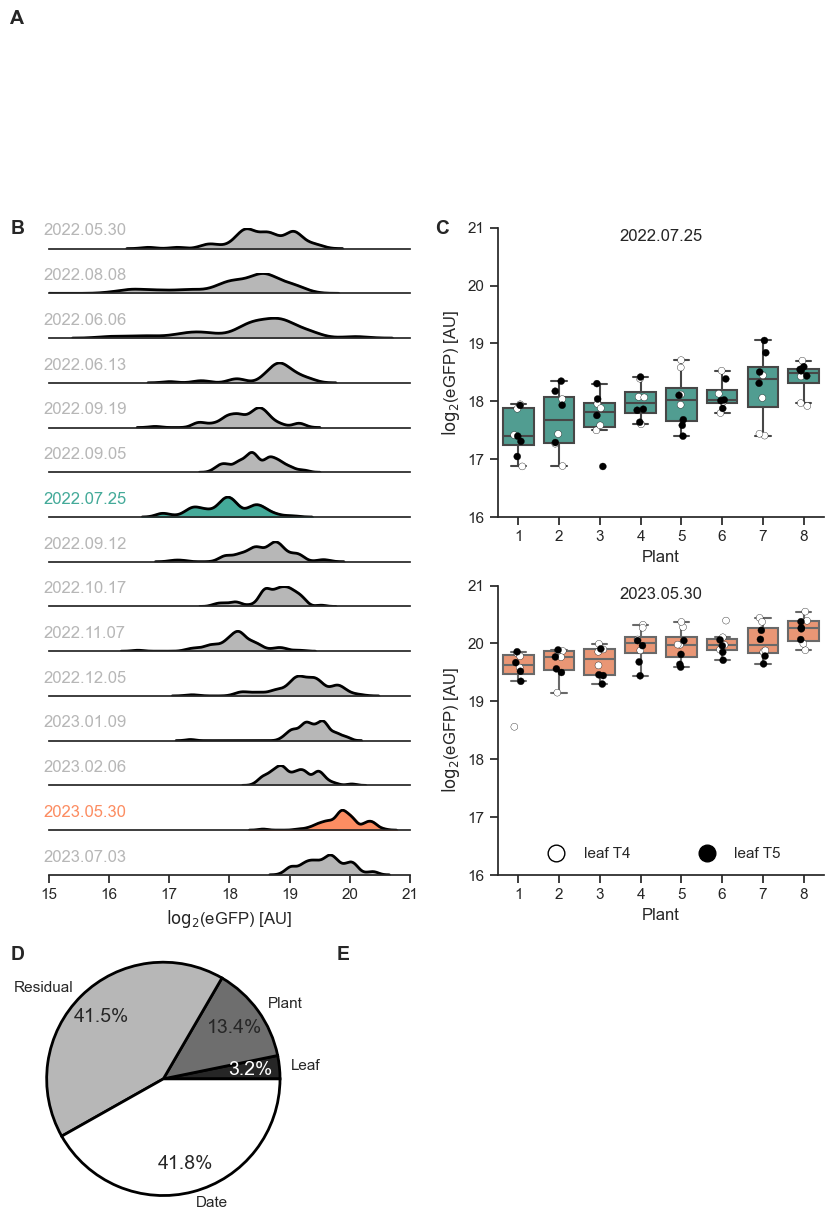

In [18]:
fig1 = plt.figure(figsize=(10, 12), constrained_layout=False)
heights = [0.5]*15 + [2, 3.5]
widths = [3.5, 1.4, 0.1, 5]
spec = gridspec.GridSpec(ncols=4, nrows=17, figure=fig1, height_ratios=heights, width_ratios=widths, wspace=0.25, hspace=0.75)

#Define dimensions of each subplot.
axn0_list = []
for i in list(range(15)):
    axn0 = fig1.add_subplot(spec[i, 0:2])
    axn0_list = axn0_list + [axn0]

fig_ax01 = fig1.add_subplot(spec[0:7, 3])
fig_ax11 = fig1.add_subplot(spec[8:15, 3])
fig_ax20 = fig1.add_subplot(spec[16, 0])

#Fig. 1B
for date in list(historical_df.Date.unique()):
    i = list(historical_df.Date.unique()).index(date)
    sns.kdeplot(data=historical_df[historical_df.Date == date], x='log2egfp', fill=True, ax=axn0_list[i], alpha=1, linewidth=2, bw_adjust=0.5, color=fig1_pal[date]).set(xlim=(15, 21), xlabel='', ylabel='')
    sns.kdeplot(data=historical_df[historical_df.Date == date], x='log2egfp', fill=False, ax=axn0_list[i], alpha=1, linewidth=2, bw_adjust=0.5, color='black').set(xlim=(15, 21), xlabel='', ylabel=date)
    axn0_list[i].yaxis.label.set(ha='left', rotation='horizontal', color=fig1_pal[date])
    axn0_list[i].set_xticks([])
    axn0_list[i].set_yticks([])
    sns.despine(ax=axn0_list[i], left=True)

axn0_list[len(axn0_list)-1].set_xticks(list(range(15, 22)))
axn0_list[len(axn0_list)-1].set_xlabel(r'$\rm{log}_{2}$(eGFP) [AU]')

#Fig. 1C - top
df_low = historical_df[historical_df.Date == '2022.07.25']
order_low = df_low.groupby('Plant')['log2egfp'].mean().sort_values().index.to_list()
sns.boxplot(data=df_low, x='Plant', y='log2egfp', color=fig1_pal['2022.07.25'], order=order_low, width=.75, fliersize=0, ax=fig_ax01).set(xticklabels=np.arange(1,9), ylim=(16, 21), ylabel=r'$\rm{log}_{2}$(eGFP) [AU]')
sns.stripplot(data=df_low, x='Plant', y='log2egfp', hue='Leaf', s=5, edgecolor='black', order=order_low, linewidth=0.25, legend=False,
                   palette=[sns.color_palette(["#FFFFFF"])[0], sns.color_palette(["#000000"])[0]], ax=fig_ax01)
fig_ax01.set_title('2022.07.25', y=0.925)

#Fig. 1C - bottom
df_high = historical_df[historical_df.Date == '2023.05.30']
order_high = df_high.groupby('Plant')['log2egfp'].mean().sort_values().index.to_list()

sns.boxplot(data=df_high, x='Plant', y='log2egfp', color=fig1_pal['2023.05.30'], order=order_high, width=.75, fliersize=0, ax=fig_ax11).set(xticklabels=np.arange(1,9), ylim=(16, 21), ylabel=r'$\rm{log}_{2}$(eGFP) [AU]')
sns.stripplot(data=df_high, x='Plant', y='log2egfp', hue='Leaf', s=5, edgecolor='black', order=order_high, linewidth=0.25, legend=True,
                   palette=[sns.color_palette(["#FFFFFF"])[0], sns.color_palette(["#000000"])[0]], ax=fig_ax11)
fig_ax11.set_title('2023.05.30', y=0.925)

t4_handle = lines.Line2D([], [], marker='o', linestyle='', color='white',  markeredgecolor='black', label='leaf T4')
t5_handle = lines.Line2D([], [], marker='o', linestyle='', color='black',  markeredgecolor='black', label='leaf T5')
fig_ax11.legend(handles=[t4_handle, t5_handle], loc='lower center', ncols=2, frameon=False, markerscale=2, columnspacing=4)

#Fig. 1D
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        return '{:.1f}%'.format(pct)
    return my_format

patches, texts, autotexts = fig_ax20.pie(mem_var[mem_var.ID == 'PC4_Bulk'].Percent, colors=sns.color_palette("dark:#FFFFFF", 4), labels=mem_var[mem_var.ID == 'PC4_Bulk'].Component, 
             wedgeprops={'linewidth': 2, 'edgecolor': "black", 'antialiased': True}, 
             autopct=autopct_format(mem_var[mem_var.ID == 'PC4_Bulk'].Percent), pctdistance=0.75, radius=2)
autotexts[0].set_color('white')

fig1.text(0.1, 1.05, 'A', fontdict={'weight':'bold'}, ha='right')
fig1.text(0.1, 0.875, 'B', fontdict={'weight':'bold'}, ha='right')
fig1.text(0.525, 0.875, 'C', fontdict={'weight':'bold'}, ha='right')
fig1.text(0.1, 0.27, 'D', fontdict={'weight':'bold'}, ha='right')
fig1.text(0.425, 0.27, 'E', fontdict={'weight':'bold'}, ha='right')

fig1.savefig('../03-figures/figure1.svg', format='svg', bbox_inches='tight')

FP CO-DELIVERY COMPARISON<br>
3 methods of co-delivery (co-infiltration, same T-DNA, and BiBi) were compared to eGFP or mCherry alone.<br>
Co-infiltration and BiBi varied origins of replication (pVS1, BBR1, and pSa). Same T-DNA varied cassette oritentation relative to one another and to the LB/RB.<br>
6 plants/condition, 2 leaves/plant, 4 punches/leaf.

In [19]:
nplants = 6
conds = ['1. pVS1:G', '2. pVS1:R', #single strains, no normalization
         '3. pVS1:G & pVS1:R', '4. pVS1:G & BBR1:R', '5. pVS1:R & BBR1:G', '6. pVS1:G & pSa:R', '7. pVS1:R & pSa:G', #co-infiltrations
         '8. G→R→', '9. R→G→', '10. G→←R', '11. R→←G', '12. ←G←R', '13. ←R←G', '14. ←GR→', '15. ←RG→', #2 FP/T-DNA
         '16. pVS1:G + BBR1:R', '17. pVS1:R + BBR1:G', '18. pVS1:G + pSa:R', '19. pVS1:R + pSa:G'] #BiBis
nconds = len(conds)

#Combine data from two replicates into one DataFrame.
df_1 = read_plate_data('../01-data/241021_codeliverycompare.xlsx', '2024.10.21', 2)
df_2 = read_plate_data('../01-data/241028_codeliverycompare.xlsx', '2024.10.28', 2)
codel_df = pd.concat([df_1, df_2]) 
codel_df.reset_index(inplace=True, drop=True)

#Add condition information to DataFrame.
cond_list = []
for cond in conds:
    cond_list = cond_list + [cond]*nplants*nleaves*npunches
df_1['Condition'] = cond_list
df_2['Condition'] = cond_list
codel_df['Condition'] = cond_list*2

drop_duds(df_1, 1000, 100)
drop_duds(df_2, 1000, 100)
drop_duds(codel_df, 1000, 100)

In [20]:
#Calculate CVs for individual replicates and all data, pooled.
cv_1 = calc_cv(df_1) 
cv_2 = calc_cv(df_2) 
cv_1['Date'] = '2024.10.21'
cv_2['Date'] = '2024.10.28'

codel_cv = calc_cv(codel_df) #CVs for all data, pooled
codel_cv_aggregate = pd.concat([cv_1, cv_2]) #CVs separated by replicate

In [21]:
#Calculate CVs for each plant from its 8 leaf discs.
codel_cv_by_plant = calc_cv_by_plant(codel_df)

#For conditions with only 1 FP, replace the absent FP's CV and ratio CVs with np.NaN.
codel_cv_by_plant.loc[list(codel_cv_by_plant[codel_cv_by_plant.Condition == '1. pVS1:G'].index), ['mCherry CV', 'eGFP/mCherry CV', 'mCherry/eGFP CV']] = np.NaN
codel_cv_by_plant.loc[list(codel_cv_by_plant[codel_cv_by_plant.Condition == '2. pVS1:R'].index), ['eGFP CV', 'eGFP/mCherry CV', 'mCherry/eGFP CV']] = np.NaN

#Create one DataFrame to compare cond 1's eGFP CV to eGFP/mCherry CVs and cond 2's mCherry CV to mCherry/eGFP CVs.
melted_green_cv, melted_red_cv = melt_cv(codel_cv_by_plant, '1. pVS1:G', '2. pVS1:R')

In [22]:
#Uncorrected 1-tailed Welch's t-test to check if cond 1's eGFP CV is lower than the cond's eGFP/mCherry CV.
green_welchs_uncorrected = []
for cond in conds[2:]:
    green_welchs_uncorrected = green_welchs_uncorrected + [stats.ttest_ind(codel_cv_by_plant[codel_cv_by_plant.Condition == '1. pVS1:G']['eGFP CV'], 
                                                                           codel_cv_by_plant[codel_cv_by_plant.Condition == cond]['eGFP/mCherry CV'], 
                                                                           alternative='greater', equal_var=False)[1]]

#Bonferroni correction
green_welchs_correct = mt.multipletests(green_welchs_uncorrected, method='bonf')

green_welchs = pd.DataFrame(index=conds[2:], data={'pval':green_welchs_uncorrected, 'pval_corr':green_welchs_correct[1], 'reject':green_welchs_correct[0]})
green_welchs[green_welchs.reject]

,pval,pval_corr,reject
3. pVS1:G & pVS1:R,0.000069,0.001175,True
7. pVS1:R & pSa:G,0.000827,0.014060,True
8. G→R→,0.000648,0.011018,True
9. R→G→,0.001133,0.019260,True
10. G→←R,0.000234,0.003976,True
11. R→←G,0.000287,0.004880,True
12. ←G←R,0.000320,0.005443,True
13. ←R←G,0.001860,0.031628,True
14. ←GR→,0.000328,0.005571,True
19. pVS1:R + pSa:G,0.000263,0.004463,True


In [23]:
#Uncorrected 1-tailed Welch's t-test to check if cond 1's eGFP CV is lower than the cond's eGFP/mCherry CV.
red_welchs_uncorrected = []
for cond in conds[2:]:
    red_welchs_uncorrected = red_welchs_uncorrected + [stats.ttest_ind(codel_cv_by_plant[codel_cv_by_plant.Condition == '2. pVS1:R']['mCherry CV'], 
                                                                       codel_cv_by_plant[codel_cv_by_plant.Condition == cond]['mCherry/eGFP CV'], 
                                                                       alternative='greater', equal_var=False)[1]]

#Bonferroni correction
red_welchs_correct = mt.multipletests(red_welchs_uncorrected, method='bonf')

red_welchs = pd.DataFrame(index=conds[2:], data={'pval':red_welchs_uncorrected, 'pval_corr':red_welchs_correct[1], 'reject':red_welchs_correct[0]})
red_welchs[red_welchs.reject]

,pval,pval_corr,reject
3. pVS1:G & pVS1:R,0.001148,0.019513,True


In [24]:
def calc_top_whisker(cond, df, var):
    boollist = []
    q3, q1 = np.percentile(df[df.Condition == cond][var], [75 ,25])
    
    for cv in df[df.Condition == cond][var]:
        boollist = boollist + [cv < ((q3 - q1)*1.5 + q3)]
    
    return np.max(df[df.Condition == cond][boollist][var])

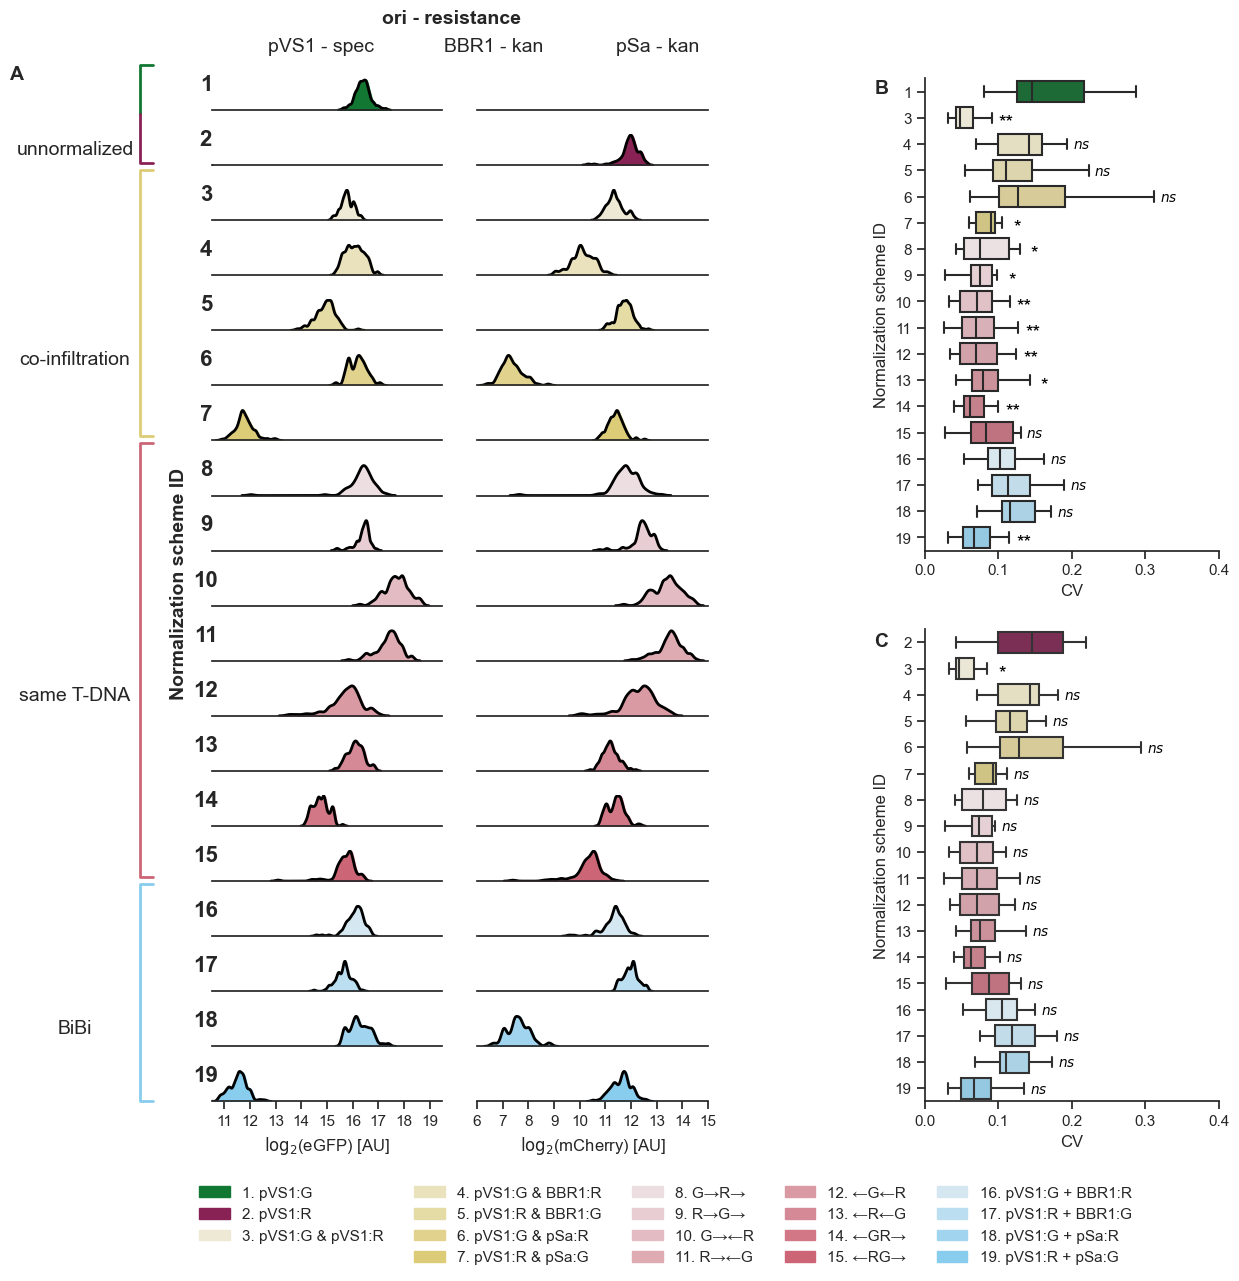

In [25]:
fig2 = plt.figure(figsize=(13, 14), constrained_layout=False)
heights = [0.5]*20
widths = [3.75, 0.25, 0.25, 3.75, 3, 6]
spec = gridspec.GridSpec(ncols=6, nrows=20, figure=fig2, height_ratios=heights, width_ratios=widths, wspace=0.25, hspace=0.75)

#Define dimensions of each subplot.
axn0_list = []
axn1_list = []
for i in range(19):
    axn0 = fig2.add_subplot(spec[i+1, 0:2])
    axn1 = fig2.add_subplot(spec[i+1, 2:4])
    axn0_list.append(axn0)
    axn1_list.append(axn1)

fig_ax02 = fig2.add_subplot(spec[1:10,5])
fig_ax12 = fig2.add_subplot(spec[11:,5])

#Fig. 2A
for cond in conds:
    i = conds.index(cond)

    #eGFP distributions
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2green', fill=True, ax=axn0_list[i], alpha=1, linewidth=2, bw_adjust=0.5, clip=(10.5,19.5), color=custom_palette[i]).set(xlim=(10.5, 19.5), xlabel='')
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2green', fill=False, ax=axn0_list[i], alpha=1, linewidth=2, bw_adjust=0.5, clip=(10.5,19.5), color='black').set(xlim=(10.5, 19.5), xlabel='', ylabel=i+1)
    axn0_list[i].yaxis.label.set(fontsize=16, fontweight='bold', rotation='horizontal')
    axn0_list[i].set_xticks([])
    axn0_list[i].set_yticks([])
    sns.despine(ax=axn0_list[i], left=True)

    #mCherry distributions
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2red', fill=True, ax=axn1_list[i], alpha=1, linewidth=2, bw_adjust=0.5, clip=(6.2, 16), color=custom_palette[i]).set(xlim=(6.35, 15), xlabel='', ylabel='')
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2red', fill=False, ax=axn1_list[i], alpha=1, linewidth=2, bw_adjust=0.5, clip=(6.2, 16), color='black').set(xlim=(6.35, 15), xlabel='', ylabel='')
    axn1_list[i].set_xticks([])
    axn1_list[i].set_yticks([])
    sns.despine(ax=axn1_list[i], left=True)
    
axn0_list[len(axn0_list)-1].set_xticks(list(range(11, 20)))
axn1_list[len(axn1_list)-1].set_xticks(list(range(6, 16)))
axn0_list[len(axn0_list)-1].set_xlabel(r'$\rm{log}_{2}$(eGFP) [AU]')
axn1_list[len(axn1_list)-1].set_xlabel(r'$\rm{log}_{2}$(mCherry) [AU]')
fig2.text(0.1, 0.48, 'Normalization scheme ID', rotation=90, fontdict={'weight':'bold'}, ha='center', va='center')

#Fig. 2B
codel_box_g = sns.boxplot(data=melted_green_cv, y='Condition', x='CV', hue='Condition', palette=([custom_palette[0]] + custom_palette[2:]), fliersize=0, dodge=False, orient='h', ax=fig_ax02).set(yticklabels=[1]+ list(range(3, 20)), xlim=(0,0.4), ylabel='Normalization scheme ID')
fig_ax02.legend('', frameon=False)

#Fig. 2C
codel_box_r = sns.boxplot(data=melted_red_cv, y='Condition', x='CV', hue='Condition', palette=custom_palette[1:], fliersize=0, dodge=False, orient='h', ax=fig_ax12).set(yticklabels=list(range(2, 20)), xlim=(0,0.4), ylabel='Normalization scheme ID')
fig_ax12.legend('', frameon=False)

#Add ori legend
fig2.text(0.31, 0.88, 'ori - resistance', fontdict={'weight':'bold'}, ha='center')
fig2.text(0.25, 0.86, 'pVS1 - spec', ha='right')
fig2.text(0.38, 0.86, 'BBR1 - kan', ha='right')
fig2.text(0.50, 0.86, 'pSa - kan', ha='right')

#Add bracket labels
fig2.text(0.02, 0.79, 'unnormalized', va='center', ha='center')
fig2.text(0.02, 0.64, 'co-infiltration', va='center', ha='center')
fig2.text(0.02, 0.4, 'same T-DNA', va='center', ha='center')
fig2.text(0.02, 0.1625, 'BiBi', va='center', ha='center')

#Add colored brackets
fig2.add_artist(lines.Line2D([0.08, 0.07, 0.07], [0.85, 0.85, 0.815], linewidth=2, color=custom_palette[0])) #green - eGFP
fig2.add_artist(lines.Line2D([0.08, 0.07, 0.07], [0.78, 0.78, 0.815], linewidth=2, color=custom_palette[1])) #magenta - mCherry
fig2.add_artist(lines.Line2D([0.08, 0.07, 0.07, 0.08], [0.775, 0.775, 0.585, 0.585], linewidth=2, color=custom_palette[6])) #yellow - co-infiltration
fig2.add_artist(lines.Line2D([0.08, 0.07, 0.07, 0.08], [0.58, 0.58, 0.27, 0.27], linewidth=2, color=custom_palette[14])) #pink - same T-DNA
fig2.add_artist(lines.Line2D([0.08, 0.07, 0.07, 0.08], [0.265, 0.265, 0.11, 0.11], linewidth=2, color=custom_palette[18])) # blue - BiBi

#Add significance bars.
for cond in conds[2:]:
    xg = calc_top_whisker(cond, codel_cv_by_plant, 'eGFP/mCherry CV')
    xr = calc_top_whisker(cond, codel_cv_by_plant, 'mCherry/eGFP CV')
    y = conds.index(cond)-1.15
    fig_ax02.text(xg+0.02, y, sig_char(cond, 'pval_corr', green_welchs), color='black', ha='center', va='top')
    fig_ax12.text(xr+0.02, y, sig_char(cond, 'pval_corr', red_welchs), color='black', ha='center', va='top')

fig2.text(-0.03, 0.84, 'A', fontdict={'weight':'bold'})
fig2.text(0.635, 0.83, 'B', fontdict={'weight':'bold'})
fig2.text(0.635, 0.435, 'C', fontdict={'weight':'bold'})

#Add condition legend
handles = []
for cond in conds:
    patch = mpatches.Patch(color=custom_palette[conds.index(cond)], label=cond)
    handles = handles + [patch]
handles.insert(3, mpatches.Patch(color='white', label=''))
plt.legend(handles=handles, ncol=5, bbox_to_anchor=(0.75, -0.15), frameon=False)

fig2.savefig('../03-figures/figure2.svg', format='svg', bbox_inches='tight')

In [26]:
#For same T-DNA conds, all v. all two-tailed Welch's t-test to test eGFP.
sametdna_green_welchs = []
group1 = []
group2 = []

for cond in conds[7:14]:
    first_df = codel_df[codel_df.Condition == cond]['eGFP']
    
    for next_cond in conds[conds.index(cond)+1:15]:
        second_df = codel_df[codel_df.Condition == next_cond]['eGFP']
        sametdna_green_welchs = sametdna_green_welchs + [stats.ttest_ind(first_df, second_df, equal_var=False)[1]]
        group1 = group1 + [cond]
        group2 = group2 + [next_cond]

#Bonferroni correction
sametdna_green_welchs_correct = mt.multipletests(sametdna_green_welchs, method='bonf')

sametdna_green_welchs_correct = pd.DataFrame(data={'group1': group1, 'group2':group2, 'pval':sametdna_green_welchs, 'pval_corr':sametdna_green_welchs_correct[1], 'reject':sametdna_green_welchs_correct[0]})
sametdna_green_welchs_correct[~sametdna_green_welchs_correct.reject] #displays conds in the same significance group

,group1,group2,pval,pval_corr,reject
0,8. G→R→,9. R→G→,0.812325,1.0,False
24,12. ←G←R,15. ←RG→,0.149444,1.0,False


In [27]:
#For same T-DNA conds, all v. all two-tailed Welch's t-test to test mCherry.
sametdna_red_welchs = []
group1 = []
group2 = []

for cond in conds[7:14]:
    first_df = codel_df[codel_df.Condition == cond]['mCherry']
    
    for next_cond in conds[conds.index(cond)+1:15]:
        second_df = codel_df[codel_df.Condition == next_cond]['mCherry']
        sametdna_red_welchs = sametdna_red_welchs + [stats.ttest_ind(first_df, second_df, equal_var=False)[1]]
        group1 = group1 + [cond]
        group2 = group2 + [next_cond]

#Bonferroni correction
sametdna_red_welchs_correct = mt.multipletests(sametdna_red_welchs, method='bonf')

sametdna_red_welchs_correct = pd.DataFrame(data={'group1': group1, 'group2':group2, 'pval':sametdna_red_welchs, 'pval_corr':sametdna_red_welchs_correct[1], 'reject':sametdna_red_welchs_correct[0]})
sametdna_red_welchs_correct[~sametdna_red_welchs_correct.reject] #displays conds in the same significance group

,group1,group2,pval,pval_corr,reject
9,9. R→G→,12. ←G←R,0.261060,1.0,False
13,10. G→←R,11. R→←G,0.258619,1.0,False


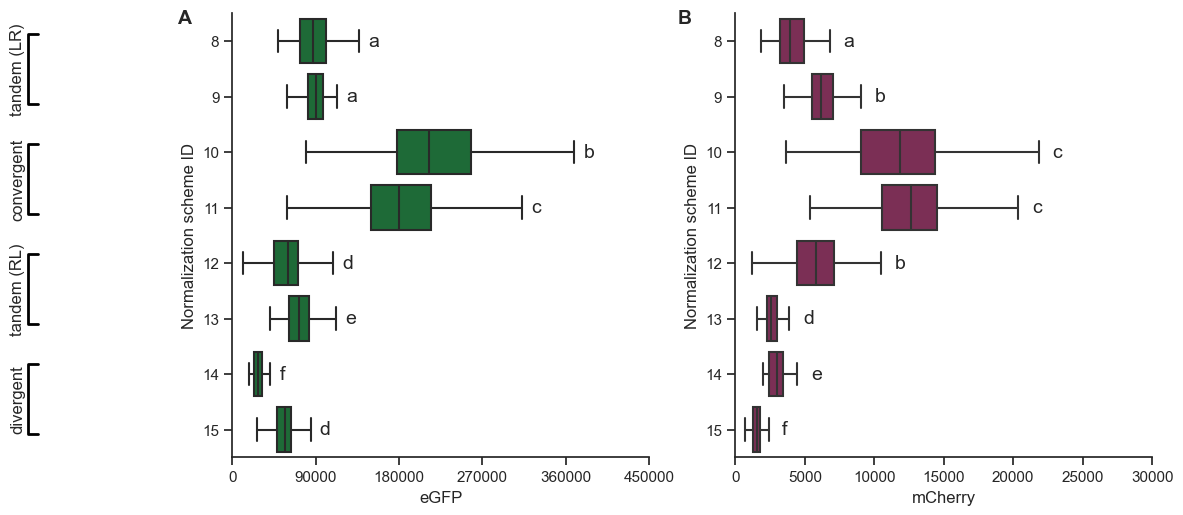

In [28]:
fig3, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)

sametdna_df = codel_df[codel_df.Condition.str.contains('|'.join(conds[7:15]), case=False)]

sns.boxplot(data=sametdna_df, y='Condition', x='eGFP', fliersize=0, color=custom_palette[0], ax=axs[0]).set(xlim=(0, 450000))
axs[0].set_xticks(list(range(0, 450001, 90000)))
axs[0].set_yticklabels(list(range(8, 16)))
axs[0].set_ylabel('Normalization scheme ID')

sns.boxplot(data=sametdna_df, y='Condition', x='mCherry', fliersize=0, color=custom_palette[1], ax=axs[1]).set(xlim=(0, 30000))
axs[1].set_yticklabels(list(range(8, 16)))
axs[1].set_ylabel('Normalization scheme ID')

#Add configuration brackets and descriptions
fig3.add_artist(lines.Line2D([-0.14, -0.15, -0.15, -0.14], [0.95, 0.95, 0.81, 0.81], linewidth=2, color='black'))
fig3.text(-0.16, 0.88, 'tandem (LR)', rotation=90, ha='center', va='center', fontdict={'size':12})
fig3.add_artist(lines.Line2D([-0.14, -0.15, -0.15, -0.14], [0.73, 0.73, 0.59, 0.59], linewidth=2, color='black'))
fig3.text(-0.16, 0.66, 'convergent', rotation=90, ha='center', va='center', fontdict={'size':12})
fig3.add_artist(lines.Line2D([-0.14, -0.15, -0.15, -0.14], [0.51, 0.51, 0.37, 0.37], linewidth=2, color='black'))
fig3.text(-0.16, 0.44, 'tandem (RL)', rotation=90, ha='center', va='center', fontdict={'size':12})
fig3.add_artist(lines.Line2D([-0.14, -0.15, -0.15, -0.14], [0.29, 0.29, 0.15, 0.15], linewidth=2, color='black'))
fig3.text(-0.16, 0.22, 'divergent', rotation=90, ha='center', va='center', fontdict={'size':12})

#Add significance groups.
sig_chars = 'aabcdefd'
for cond in list(sametdna_df.Condition.unique()):
    i = list(sametdna_df.Condition.unique()).index(cond)
    axs[0].text(calc_top_whisker(cond, sametdna_df, 'eGFP')+10000, i, sig_chars[i], va='center')

sig_chars = 'abccbdef'
for cond in list(sametdna_df.Condition.unique()):
    i = list(sametdna_df.Condition.unique()).index(cond)
    axs[1].text(calc_top_whisker(cond, sametdna_df, 'mCherry')+1000, i, sig_chars[i], va='center')

fig3.text(0, 1, 'A', va='top', fontdict={'weight':'bold'})
fig3.text(0.5, 1, 'B', va='top', fontdict={'weight':'bold'})

fig3.savefig('../03-figures/figure3.svg', format='svg', bbox_inches='tight')

In [29]:
min_gfp = '14. ←GR→'
max_gfp =  '10. G→←R'
min_mcherry = '15. ←RG→' 
max_mcherry = '11. R→←G'

print(np.mean(sametdna_df[sametdna_df.Condition == max_gfp].eGFP) / np.mean(sametdna_df[sametdna_df.Condition == min_gfp].eGFP)) #fold difference in highest and lowest green conds
print(np.mean(sametdna_df[sametdna_df.Condition == max_mcherry].mCherry) / np.mean(sametdna_df[sametdna_df.Condition == min_mcherry].mCherry)) #fold difference in highest and lowest red conds

7.944458300235085
8.322347199760934


OD OPTIMIZATION EXPERIMENT <br>
mCherry OD and green OD were added at 0, 0.01, 0.1, 0.5, or 1 in every possible combination, for a total of 24 combinations. <br>
6 plants/condition, 2 leaves/plant, 4 punches/leaf.

In [30]:
nplants = 6

#Condition labels are in the format of '(eGFP OD) - (mCherry OD)'.
conds = ['1 - 0', '1 - 0.01', '1 - 0.1', '1 - 0.5', '1 - 1', 
        '0.5 - 0', '0.5 - 0.01', '0.5 - 0.1', '0.5 - 0.5', '0.5 - 1', 
        '0.1 - 0', '0.1 - 0.01', '0.1 - 0.1', '0.1 - 0.5', '0.1 - 1', 
        '0.01 - 0', '0.01 - 0.01', '0.01 - 0.1', '0.01 - 0.5', '0.01 - 1', 
        '0 - 0.01', '0 - 0.1', '0 - 0.5', '0 - 1']
nconds = len(conds)

od_df = read_plate_data('../01-data/240812_ODoptimize.xlsx', '2024.08.12', 2)
annotate_ods(od_df, conds)
drop_duds(od_df, 1500, 70)

In [31]:
#Calculate CVs for each OD combination.
od_cv = calc_cv(od_df)

#Annotate od_cv DataFrame with green and red OD information.
od_cv['eGFP OD'] = [1]*5 + [0.5]*5 + [0.1]*5 + [0.01]*5 + [0]*4
od_cv['mCherry OD'] = [0, 0.01, 0.1, 0.5, 1]*4 + [0.01, 0.1, 0.5, 1]

#In the 5x5 matrix, there is a cell that corresponds to the condition wherein OD=0 for both strains. 
#A row for this condition is inserted to facilitate later making a 5x5 heatmap, and its values are filled with np.NaN.
od_cv.loc[24] = [np.NaN] * 4 + ['0 - 0', 0.00, 0.00]

modify_single_strains(od_cv, 'eGFP OD', 'mCherry OD', 0.00)
od_cv = od_cv.sort_values(by=['eGFP OD', 'mCherry OD'], ascending=[False, True]).reset_index(drop=True)

In [32]:
#Calculate CVs for each plant from its 8 leaf discs.
od_cv_by_plant = calc_cv_by_plant(od_df)

#Annotate od_cv_by_plant DataFrame with green and red OD information.
od_cv_by_plant['eGFP OD'] = [1]*nplants*5 + [0.5]*nplants*5 + [0.1]*nplants*5 + [0.01]*nplants*5 + [0]*nplants*4
od_cv_by_plant['mCherry OD'] = ([0]*nplants + [0.01]*nplants + [0.1]*nplants + [0.5]*nplants + [1]*nplants)*4 + [0.01]*nplants + [0.1]*nplants + [0.5]*nplants + [1]*nplants

#For conditions with only 1 FP, replace the absent FP's CV and ratio CVs with np.NaN.
modify_single_strains(od_cv_by_plant, 'eGFP OD', 'mCherry OD', 0.00)

#All v. all Bonferroni-corrected two-tailed, independent Student's t-test comparing all two-strain conds' plant eGFP/mCherry CVs. Prints number of rejected null hypotheses.
np.sum(all_ttest(od_cv_by_plant[(od_cv_by_plant['eGFP OD'] != 0) & (od_cv_by_plant['mCherry OD'] != 0)], 'Condition', 'eGFP/mCherry CV').reject)

0

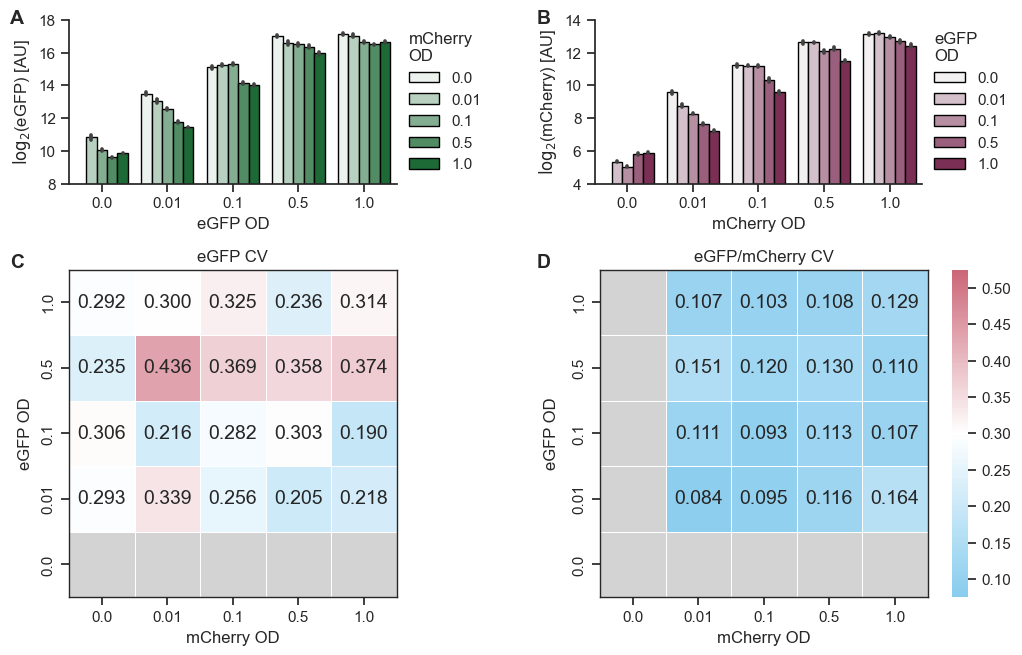

In [33]:
fig4 = plt.figure(figsize=(13,7.5), constrained_layout=False)
heights = [2.5, 5]
widths = [4, 0.05, 4, 0.05]
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig4, height_ratios=heights, width_ratios=widths, hspace=0.35)

#Define dimensions of each subplot.
fig_ax00 = fig4.add_subplot(spec[0,0])
fig_ax01 = fig4.add_subplot(spec[0,2])
fig_ax10 = fig4.add_subplot(spec[1,0])
fig_ax11 = fig4.add_subplot(spec[1,2:])

#Fig. 2A
od_log2green = sns.barplot(od_df, x='eGFP OD', y='log2green', hue='mCherry OD', order=[0, 0.01, 0.1, 0.5, 1], edgecolor='black', linewidth=1, 
            palette=sns.color_palette("light:#117733", 5), errorbar='se', ax=fig_ax00).set_xticklabels([0.0, 0.01, 0.1, 0.5, 1.0])
fig_ax00.set_ylabel(r'$\rm{log}_{2}$(eGFP) [AU]')
fig_ax00.set_aspect(0.25)
fig_ax00.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='mCherry\nOD', frameon=False, alignment='left')
fig_ax00.set_ylim(8, 18)

#Fig. 2B
od_log2red= sns.barplot(od_df, x='mCherry OD', y='log2red', hue='eGFP OD', order=[0, 0.01, 0.1, 0.5, 1], edgecolor='black', linewidth=1, 
            palette=sns.color_palette("light:#882255", 5), errorbar='se', ax=fig_ax01).set_xticklabels([0.0, 0.01, 0.1, 0.5, 1.0])
fig_ax01.set_ylabel(r'$\rm{log}_{2}$(mCherry) [AU]')
fig_ax01.set_aspect(0.25)
fig_ax01.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='eGFP\nOD', frameon=False, alignment='left')
fig_ax01.set_ylim(4, 14)

#Fig. 2C
od_heatmap_g = sns.heatmap(od_cv.pivot(index="eGFP OD", columns="mCherry OD", values="eGFP CV"), annot=True, cbar=False,
                         cmap=cmap, fmt=".3f", square=True, vmin=0.075, vmax=0.525, linewidth=0.5, ax=fig_ax10)
od_heatmap_g.set_ylabel('eGFP OD', labelpad=6)
od_heatmap_g.invert_yaxis()
od_heatmap_g.set(title='eGFP CV')
for _, spine in od_heatmap_g.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. 2D
od_heatmap_gr = sns.heatmap(od_cv.pivot(index="eGFP OD", columns="mCherry OD", values="eGFP/mCherry CV"), annot=True, 
                         cmap=cmap, fmt=".3f", square=True, vmin=0.075, vmax=0.525, linewidth=0.5, ax=fig_ax11)
od_heatmap_gr.set_ylabel('eGFP OD', labelpad=10)
od_heatmap_gr.invert_yaxis()
od_heatmap_gr.set(title='eGFP/mCherry CV')
for _, spine in od_heatmap_gr.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

fig4.text(0.12, 0.875, 'A', fontdict={'weight':'bold'})
fig4.text(0.525, 0.875, 'B', fontdict={'weight':'bold'})
fig4.text(0.12, 0.55, 'C', fontdict={'weight':'bold'})
fig4.text(0.525, 0.55, 'D', fontdict={'weight':'bold'})

fig4.savefig('../03-figures/figure4.svg', bbox_inches='tight')

PROMOTER OPTIMIZATION EXPERIMENT<br>
eGFP driven by PCL2, PCM2, or PCH5 was infiltrated with mCherry driven by the same three promoters (prefix: pr_same) or by PCL1, PCM1, or PCH4 (prefix: pr_diff) in every possible combination.<br>
All eGFP and mCherry strains were also infiltrated by themselves, for a total of 15 conditions. <br>
Co-infiltrated strains were added at an OD of 0.1 each, for a total OD of 0.2. Single-strain infiltrations were infiltrated at an OD of 0.2.<br>
6 plants/condition, 2 leaves/plant, 4 punches/leaf.

In [34]:
conds = ['PCH5:G - NA', 'PCH5:G - PCL2:R', 'PCH5:G - PCM2:R', 'PCH5:G - PCH5:R', 
        'PCM2:G - NA', 'PCM2:G - PCL2:R', 'PCM2:G - PCM2:R', 'PCM2:G - PCH5:R', 
        'PCL2:G - NA', 'PCL2:G - PCL2:R', 'PCL2:G - PCM2:R', 'PCL2:G - PCH5:R', 
        'NA - PCL2:R', 'NA - PCM2:R', 'NA - PCH5:R']
nconds = len(conds)
nplants = 6

pr_same_df = read_plate_data('../01-data/240826_promoteroptimize.xlsx', '2024.08.26', 2)
annotate_promoters(pr_same_df, conds)
drop_duds(pr_same_df, 1500, 90)

In [35]:
#Calculate CVs for each promoter pair.
pr_same_cv = calc_cv(pr_same_df)

#Annotate pr_same_cv DataFrame with green and red promoter information.
pr_same_cv['eGFP Promoter'] = ['PCH5']*4 + ['PCM2']*4 + ['PCL2']*4 + ['NA']*3
pr_same_cv['mCherry Promoter'] = ['NA', 'PCL2', 'PCM2', 'PCH5']*3 + ['PCL2', 'PCM2', 'PCH5']

#In the 4x4 matrix, there is a cell that corresponds to the condition wherein OD=0 for both strains. 
#A row for this condition is inserted to facilitate later making a 4x4 heatmap, and its values are filled with np.NaN.
pr_same_cv.loc[15] = [np.NaN]*4 + ['NA - NA', 'NA', 'NA']
pr_same_cv = pr_same_cv.reindex(list(range(12)) + [15] + list(range(12, 15))).reset_index(drop=True)

#Replace meaningless values (i.e., anything with green/red or red/green) with np.NaN for single strain infiltrations.
modify_single_strains(pr_same_cv, 'eGFP Promoter', 'mCherry Promoter', 'NA')

In [36]:
conds = ['PCH5:G - NA', 'PCH5:G - PCL1:R', 'PCH5:G - PCM1:R', 'PCH5:G - PCH4:R', 
        'PCM2:G - NA', 'PCM2:G - PCL1:R', 'PCM2:G - PCM1:R', 'PCM2:G - PCH4:R', 
        'PCL2:G - NA', 'PCL2:G - PCL1:R', 'PCL2:G - PCM1:R', 'PCL2:G - PCH4:R', 
        'NA - PCL1:R', 'NA - PCM1:R', 'NA - PCH4:R']
nconds = len(conds)
nplants = 6

pr_diff_df = read_plate_data('../01-data/241111_promoteroptimize.xlsx', '2024.11.11', 2)
annotate_promoters(pr_diff_df, conds)
drop_duds(pr_diff_df, 1500, 90)

In [37]:
#Calculate CVs for each promoter pair.
pr_diff_cv = calc_cv(pr_diff_df)

#Annotate pr_diff_cv DataFrame with green and red promoter information.
pr_diff_cv['eGFP Promoter'] = ['PCH5']*4 + ['PCM2']*4 + ['PCL2']*4 + ['NA']*3
pr_diff_cv['mCherry Promoter'] = ['NA', 'PCL1', 'PCM1', 'PCH4']*3 + ['PCL1', 'PCM1', 'PCH4']

#In the 4x4 matrix, there is a cell that corresponds to the condition wherein OD=0 for both strains. 
#A row for this condition is inserted to facilitate later making a 4x4 heatmap, and its values are filled with np.NaN.
pr_diff_cv.loc[15] = [np.NaN]*4 + ['NA - NA', 'NA', 'NA']
pr_diff_cv = pr_diff_cv.reindex(list(range(12)) + [15] + list(range(12, 15))).reset_index(drop=True)

#Replace meaningless values (i.e., anything with green/red or red/green) with np.NaN for single strain infiltrations.
modify_single_strains(pr_diff_cv, 'eGFP Promoter', 'mCherry Promoter', 'NA')

In [38]:
same_matrices = promoter_matrix(pr_same_cv, ['NA', 'PCL2', 'PCM2', 'PCH5'], ['NA', 'PCL2', 'PCM2', 'PCH5'])
diff_matrices = promoter_matrix(pr_diff_cv, ['NA', 'PCL2', 'PCM2', 'PCH5'], ['NA', 'PCL1', 'PCM1', 'PCH4'])

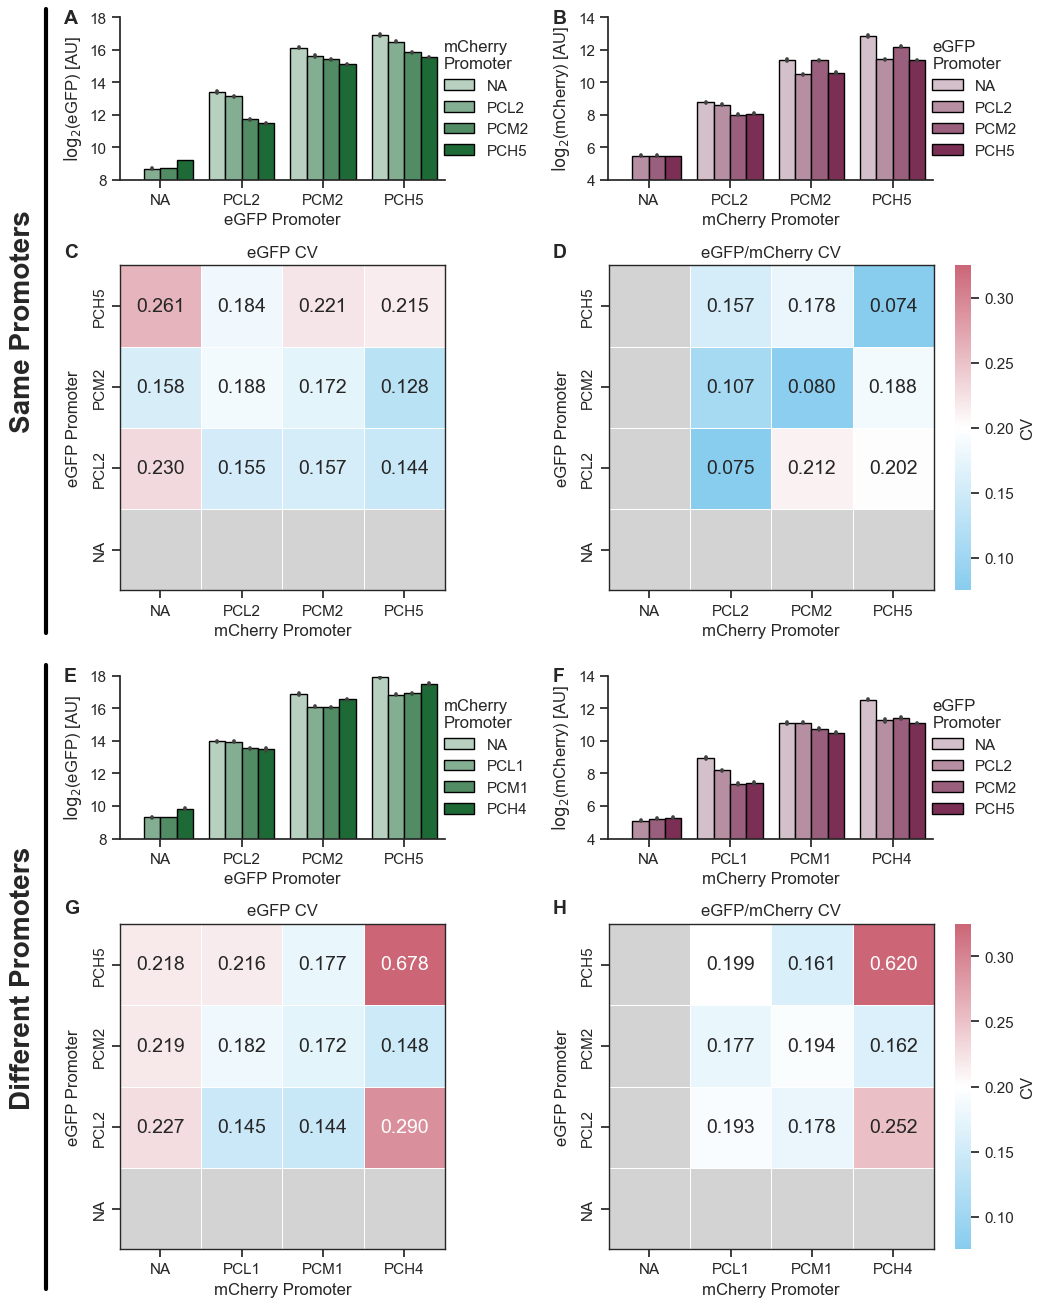

In [39]:
fig5 = plt.figure(figsize=(12,16), constrained_layout=False)
heights = [3, 6, 3, 6]
widths = [4, 0.2, 0.05, 3.95, 0.05]

spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig5, height_ratios=heights, width_ratios=widths, hspace=0.35)

fig_ax00 = fig5.add_subplot(spec[0,0])
fig_ax01 = fig5.add_subplot(spec[0,2:4])
fig_ax10 = fig5.add_subplot(spec[1,0])
fig_ax11 = fig5.add_subplot(spec[1,3:])

fig_ax20 = fig5.add_subplot(spec[2,0])
fig_ax21 = fig5.add_subplot(spec[2,2:4])
fig_ax30 = fig5.add_subplot(spec[3,0])
fig_ax31 = fig5.add_subplot(spec[3,3:])

#Fig. 5A
pr_same_log2green = sns.barplot(pr_same_df, x='eGFP Promoter', y='log2green', hue='mCherry Promoter', order=['NA', 'PCL2', 'PCM2', 'PCH5'], edgecolor='black',linewidth=1, 
                                palette=sns.color_palette("light:#117733", 5)[1:], errorbar='se', ax=fig_ax00).set(xticklabels=['NA', 'PCL2', 'PCM2', 'PCH5'])
fig_ax00.set_ylabel(r'$\rm{log}_{2}$(eGFP) [AU]')
fig_ax00.set_aspect(0.2)
fig_ax00.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='mCherry\nPromoter', frameon=False, alignment='left')
fig_ax00.set_ylim(8, 18)


#Fig. 5B 
pr_same_log2red = sns.barplot(pr_same_df, x='mCherry Promoter', y='log2red', hue='eGFP Promoter', hue_order=['NA', 'PCL2', 'PCM2', 'PCH5'], edgecolor='black', linewidth=1, 
                              palette=sns.color_palette("light:#882255", 5)[1:], errorbar='se', ax=fig_ax01).set(xticklabels=['NA', 'PCL2', 'PCM2', 'PCH5'])
fig_ax01.set_ylabel(r'$\rm{log}_{2}$(mCherry) [AU]')
fig_ax01.set_aspect(0.2)
fig_ax01.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='eGFP\nPromoter', frameon=False, alignment='left')
fig_ax01.set_ylim(4, 14)

#Fig. 5C 
pr_same_heatmap_g = sns.heatmap(data=same_matrices[0], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, cbar=False, ax=fig_ax10)
pr_same_heatmap_g.set_ylabel('eGFP Promoter', labelpad=8)
pr_same_heatmap_g.set_xlabel('mCherry Promoter')
pr_same_heatmap_g.set(title='eGFP CV')
for _, spine in pr_same_heatmap_g.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. 5D 
pr_same_heatmap_gr = sns.heatmap(data=same_matrices[2], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, ax=fig_ax11)
pr_same_heatmap_gr.set_ylabel('eGFP Promoter', labelpad=8)
pr_same_heatmap_gr.set_xlabel('mCherry Promoter')
pr_same_heatmap_gr.set(title='eGFP/mCherry CV')
for _, spine in pr_same_heatmap_gr.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 
fig_ax11.collections[0].colorbar.set_label('CV')

#Fig. 5E
pr_diff_log2green = sns.barplot(pr_diff_df, x='eGFP Promoter', y='log2green', hue='mCherry Promoter', order=['NA', 'PCL2', 'PCM2', 'PCH5'], edgecolor='black',linewidth=1, 
                                palette=sns.color_palette("light:#117733", 5)[1:], errorbar='se', ax=fig_ax20)
fig_ax20.set_ylabel(r'$\rm{log}_{2}$(eGFP) [AU]')
fig_ax20.set_aspect(0.2)
fig_ax20.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='mCherry\nPromoter', frameon=False, alignment='left')
fig_ax20.set_ylim(8, 18)

#Fig. 5F
pr_diff_log2red = sns.barplot(pr_diff_df, x='mCherry Promoter', y='log2red', hue='eGFP Promoter', hue_order=['NA', 'PCL2', 'PCM2', 'PCH5'], edgecolor='black', linewidth=1, 
                              palette=sns.color_palette("light:#882255", 5)[1:], errorbar='se', ax=fig_ax21)
fig_ax21.set_ylabel(r'$\rm{log}_{2}$(mCherry) [AU]')
fig_ax21.set_aspect(0.2)
fig_ax21.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='eGFP\nPromoter', frameon=False, alignment='left')
fig_ax21.set_ylim(4, 14)

#Fig. 5G
pr_diff_heatmap_g = sns.heatmap(data=diff_matrices[0], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, cbar=False, ax=fig_ax30)
pr_diff_heatmap_g.set_ylabel('eGFP Promoter', labelpad=8)
pr_diff_heatmap_g.set_xlabel('mCherry Promoter')
pr_diff_heatmap_g.set(title='eGFP CV')
for _, spine in pr_diff_heatmap_g.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. 5H
pr_diff_heatmap_gr = sns.heatmap(data=diff_matrices[2], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, ax=fig_ax31)
pr_diff_heatmap_gr.set_ylabel('eGFP Promoter', labelpad=8)
pr_diff_heatmap_gr.set_xlabel('mCherry Promoter')
pr_diff_heatmap_gr.set(title='eGFP/mCherry CV')
for _, spine in pr_diff_heatmap_gr.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 
fig_ax31.collections[0].colorbar.set_label('CV')

fig5.text(0.105, 0.876, 'A', fontdict={'weight':'bold'})
fig5.text(0.512, 0.876, 'B', fontdict={'weight':'bold'})
fig5.text(0.105, 0.73, 'C', fontdict={'weight':'bold'})
fig5.text(0.512, 0.73, 'D', fontdict={'weight':'bold'})
fig5.text(0.105, 0.465, 'E', fontdict={'weight':'bold'})
fig5.text(0.512, 0.465, 'F', fontdict={'weight':'bold'})
fig5.text(0.105, 0.32, 'G', fontdict={'weight':'bold'})
fig5.text(0.512, 0.32, 'H', fontdict={'weight':'bold'})

fig5.text(0.06, 0.69, 'Same Promoters', size='x-large', fontdict={'weight':'bold'}, va='center', rotation='vertical')
fig5.text(0.06, 0.28, 'Different Promoters', size='x-large', fontdict={'weight':'bold'}, va='center', rotation='vertical')
fig5.add_artist(lines.Line2D([0.09, 0.09], [0.885, 0.495], linewidth=3, color='black'))
fig5.add_artist(lines.Line2D([0.09, 0.09], [0.085, 0.475], linewidth=3, color='black'))

fig5.savefig('../03-figures/figure5.svg', format='svg', bbox_inches='tight')

NORMALIZATION VALIDATION EXPERIMENT <br>
pVS1(spec)_PCL2:G was selected as the reporter due to its variable outcomes when normalized. <br>
For several weeks, it was normalized with every mCherry-bearing binary vector generated thusfar for this publication. <br>
4 plants/condition, 2 leaves/plant, 4 punches/leaf. <br> 
Data from 2024.08.26 and 2024.11.11 which use 6 plants/condition. <br>

In [40]:
nplants = 4

conds = ['PCL2:G - PCL2:R', 'PCL2:G - PCM1:R', 'PCL2:G - PCM2:R', 'PCL2:G - PCH4:R', 'PCL2:G - PCH5:R', 'PCL2:G - NA', 'PCL2:G - PCL1:R']
rpr = ['NA', 'PCL1', 'PCL2', 'PCM1', 'PCM2', 'PCH4', 'PCH5']
nconds = len(conds)
df_241202 = read_plate_data('../01-data/241202_normvalidation.xlsx', '2024.12.02', 3)
annotate_promoters(df_241202, conds)

conds = ['PCL2:G - NA', 'PCL2:G - PCL1:R', 'PCL2:G - PCL2:R', 'PCL2:G - PCM1:R', 'PCL2:G - PCM2:R', 'PCL2:G - PCH4:R', 'PCL2:G - PCH5:R']
nconds = len(conds)
df_241209 = read_plate_data('../01-data/241209_normvalidation.xlsx', '2024.12.09', 3)
annotate_promoters(df_241209, conds)

df_241216 = read_plate_data('../01-data/241216_normvalidation.xlsx', '2024.12.16', 3)
annotate_promoters(df_241216, conds)

df_241223 = read_plate_data('../01-data/241223_normvalidation.xlsx', '2024.12.23', 3)
annotate_promoters(df_241223, conds)

df_241230 = read_plate_data('../01-data/241230_normvalidation.xlsx', '2024.12.30', 3)
annotate_promoters(df_241230, conds)

df_250106 = read_plate_data('../01-data/250106_normvalidation.xlsx', '2025.01.06', 3)
annotate_promoters(df_250106, conds)

df = pd.concat([df_250106, df_241230, df_241216, df_241223, df_241209, df_241202]).reset_index(drop=True)
drop_duds(df, 1500, 90)

cv = calc_cv(df)
cv['mCherry Promoter'] = rpr

In [41]:
cv_241202 = calc_cv(df_241202)
cv_241209 = calc_cv(df_241209)
cv_241216 = calc_cv(df_241216)
cv_241223 = calc_cv(df_241223)
cv_241230 = calc_cv(df_241230)
cv_250106 = calc_cv(df_250106)

cv_241202['Date'] = '2024.12.02'
cv_241209['Date'] = '2024.12.09'
cv_241216['Date'] = '2024.12.16'
cv_241223['Date'] = '2024.12.23'
cv_241230['Date'] = '2024.12.30'
cv_250106['Date'] = '2025.01.06'

aggregate_cv = pd.concat([cv_250106, cv_241230, cv_241223, cv_241216, cv_241209, cv_241202])
aggregate_cv['eGFP Promoter'] = 'PCL2'
aggregate_cv['mCherry Promoter'] = rpr*6
modify_single_strains(aggregate_cv, 'eGFP Promoter', 'mCherry Promoter', 'NA')

In [42]:
#Global eGFP/mCherry CVs (all replicates, pooled) for all conds, except for the unnormalized control which is eGFP CV.
cv_neg_added = pd.concat([pd.DataFrame(cv.loc[0, ['eGFP CV', 'mCherry Promoter']]).T.melt(['mCherry Promoter'], var_name='Statistic', value_name='CV'),
                          cv.loc[[1,2,3,4,5,6], ['eGFP/mCherry CV', 'mCherry Promoter']].melt(['mCherry Promoter'], var_name='Statistic', value_name='CV')])

#Replicate eGFP/mCherry CVs for all conds, except for the unnormalized control which is eGFP CV. Basically just cv_neg_added broken down by date.
aggregate_cv_neg_added = pd.concat([aggregate_cv.loc[0, ['eGFP CV', 'mCherry Promoter', 'Date']].melt(['mCherry Promoter', 'Date'], var_name='Statistic', value_name='CV'),
                          aggregate_cv.loc[[1,2,3,4,5,6], ['eGFP/mCherry CV', 'mCherry Promoter', 'Date']].melt(['mCherry Promoter', 'Date'], var_name='Statistic', value_name='CV')])

In [43]:
#For each cond, run a KS test between each replicate and the sum of all replicates. Also performs a Bonferroni correction. 
ks_results_g = ks(df, 'eGFP')
ks_results_gr = ks(df, 'eGFP/mCherry')
ks_results_gr.loc[:5, ['Distance', 'p value']] = np.NaN #Replace PCL2:G - NA values with np.NaN since they are not meaningful.

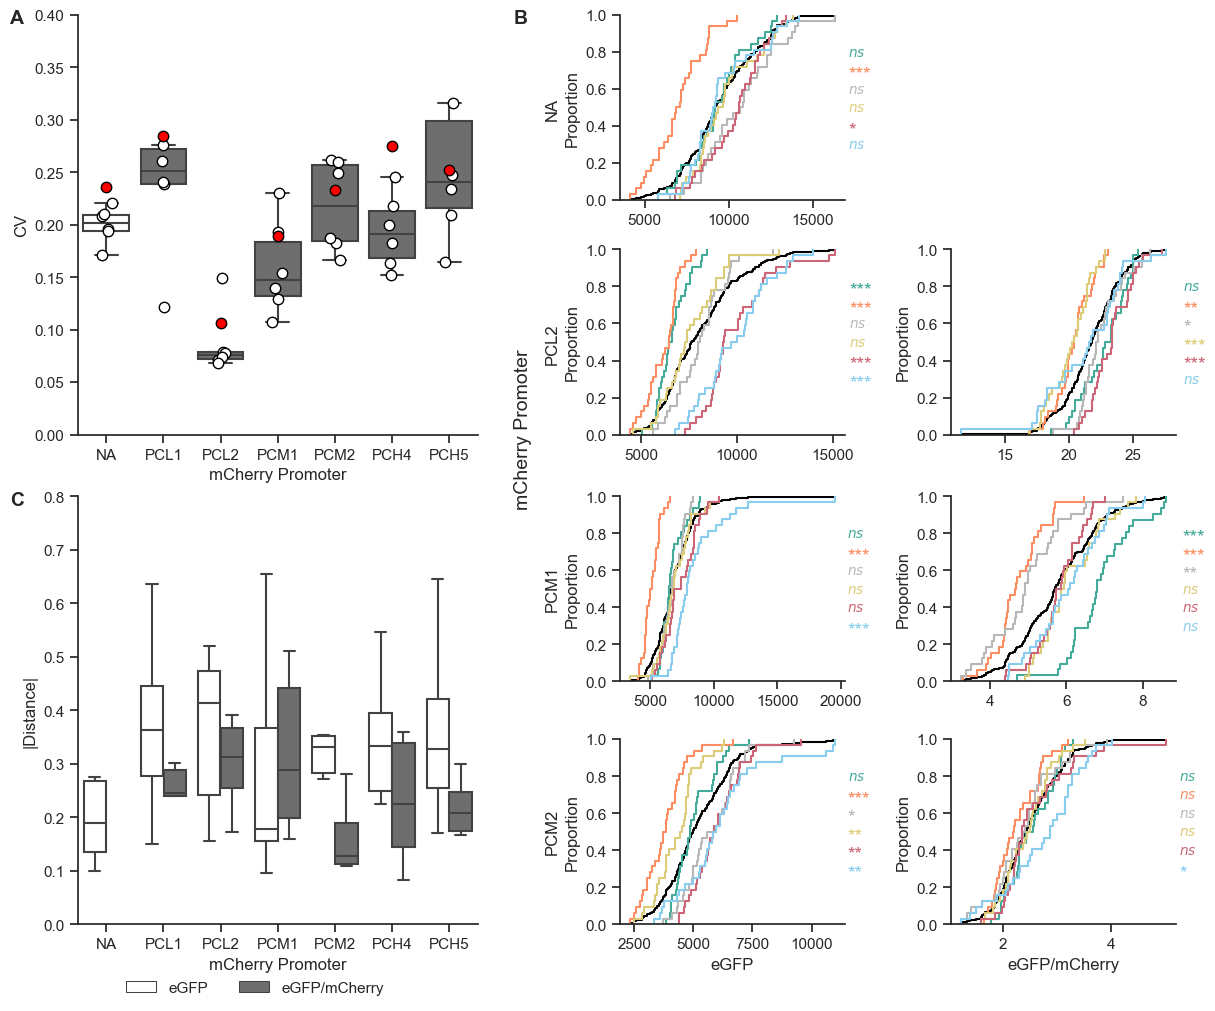

In [44]:
fig6 = plt.figure(figsize=(12, 10), constrained_layout=True)
heights = [4, 4, 4, 4]
widths = [4, 4, 1, 4.5, 4.5]
spec = gridspec.GridSpec(nrows=4, ncols=5, figure=fig6, height_ratios=heights, width_ratios=widths, wspace=0.1)

fig_ax00 = fig6.add_subplot(spec[:2,:2])
fig_ax10 = fig6.add_subplot(spec[2:,:2])
fig_ax02 = fig6.add_subplot(spec[0,3])
fig_ax03 = fig6.add_subplot(spec[0,4])
fig_ax12 = fig6.add_subplot(spec[1,3])
fig_ax13 = fig6.add_subplot(spec[1,4])
fig_ax22 = fig6.add_subplot(spec[2,3])
fig_ax23 = fig6.add_subplot(spec[2,4])
fig_ax32 = fig6.add_subplot(spec[3,3])
fig_ax33 = fig6.add_subplot(spec[3,4])

sns.despine(bottom = False, left = False)
palette=[sns.color_palette(["#44AA99"])[0], sns.color_palette(["#FC8D62"])[0], sns.color_palette("dark:#FFFFFF", 4)[2], sns.color_palette(["#DDCC77"])[0], sns.color_palette(["#CC6677"])[0], sns.color_palette(["#88CCEE"])[0]]

#Fig. 6A
#Displays the CV of each week. This does NOT include batch-to-batch variation!
sns.boxplot(data=aggregate_cv_neg_added, x='mCherry Promoter', y='CV', hue='Statistic', palette=['white', sns.color_palette("dark:#FFFFFF", 4)[1]], dodge=False, fliersize=0, ax=fig_ax00).set(ylim=(0,0.4))
sns.stripplot(data=aggregate_cv_neg_added, x='mCherry Promoter', y='CV', s=7.5, edgecolor='black', linewidth=1, color='white', ax=fig_ax00)

#Displays the CV across weeks in a red dot. This is the CV when you include batch-to-batch variation!
sns.stripplot(data=cv_neg_added, x='mCherry Promoter', y='CV', s=7.5, edgecolor='black', linewidth=1, color='red', ax=fig_ax00)
fig_ax00.legend('', frameon=False)

#Fig. 6B
ks_results_compare = pd.DataFrame(data=[ks_results_g['mCherry Promoter'], ks_results_g.Date, np.abs(ks_results_g.Distance), np.abs(ks_results_gr.Distance)], index=['mCherry Promoter', 'Date', 'eGFP', 'eGFP/mCherry']).T
sns.boxplot(ks_results_compare.melt(id_vars=['mCherry Promoter', 'Date'], value_vars=['eGFP', 'eGFP/mCherry'], var_name='Variable', value_name='|Distance|'), 
            x='mCherry Promoter', y='|Distance|', hue='Variable', palette=['white', sns.color_palette("dark:#FFFFFF", 4)[1]], fliersize=0, ax=fig_ax10).set(ylim=(0,0.8))
handles, previous_labels = fig_ax10.get_legend_handles_labels()
fig_ax10.legend(handles=handles, labels=['eGFP', 'eGFP/mCherry'], bbox_to_anchor=(0.8, -0.1), frameon=False, ncols=2)

#Fig. 6C
rpr_df = df[df['mCherry Promoter'] == 'NA'] #plot the cdf for the PCL2:G - NA condition, which has no meaningful green/red.
sns.ecdfplot(data=rpr_df, x='eGFP', ax=fig_ax02, color='black')
fig_ax02.set_title('NA', rotation='vertical', x=-0.3, y=0.4)
for date in list(df.Date.unique()):
    sns.ecdfplot(data=rpr_df[rpr_df['Date'] == date], x='eGFP', color=palette[list(df.Date.unique()).index(date)], ax=fig_ax02)
 
sig_g_cond = ks_results_g[ks_results_g['mCherry Promoter'] == 'NA'] #add Kolmogorov-Smirnov test significance symbols.
for date in list(df.Date.unique()):
    fig_ax02.text(np.max(rpr_df['eGFP'])*1.05, (0.75-0.1*list(df.Date.unique()).index(date)), sig_char(sig_g_cond[sig_g_cond['Date'] == date].index[0], 'pval', ks_results_g), fontsize=14, color=palette[list(df.Date.unique()).index(date)])
fig_ax02.set_xlabel('')
fig_ax03.axis('off')

rpr_subset = ['PCL2', 'PCM1', 'PCM2'] #plot CDFs and add significance signals for all other conditions
axs = [(fig_ax12, fig_ax13), (fig_ax22, fig_ax23), (fig_ax32, fig_ax33)]
for rpr in rpr_subset:
    rpr_df = df[df['mCherry Promoter'] == rpr]

    #Plot the global data for a condition (black line).
    sns.ecdfplot(data=rpr_df, x='eGFP', ax=axs[rpr_subset.index(rpr)][0], color='black')
    axs[rpr_subset.index(rpr)][0].set_title(rpr, rotation='vertical', x=-0.3, y=0.35)
    sns.ecdfplot(data=rpr_df, x='eGFP/mCherry', ax=axs[rpr_subset.index(rpr)][1], color='black')

    sig_g_cond = ks_results_g[ks_results_g['mCherry Promoter'] == rpr]
    sig_gr_cond = ks_results_gr[ks_results_gr['mCherry Promoter'] == rpr]

    #Plot the week-by-week data for a condition.
    for date in list(df.Date.unique()):
        #Plot the green cdf. 
        sns.ecdfplot(data=rpr_df[rpr_df['Date'] == date], x='eGFP', color=palette[list(df.Date.unique()).index(date)], ax=axs[rpr_subset.index(rpr)][0])
        axs[rpr_subset.index(rpr)][0].text(np.max(df[df['mCherry Promoter'] == rpr]['eGFP'])*1.05, (0.75-0.1*list(df.Date.unique()).index(date)), sig_char(sig_g_cond[sig_g_cond['Date'] == date].index[0], 'pval', ks_results_g), fontsize=14, color=palette[list(df.Date.unique()).index(date)])

        #Plot the green/red cdf. 
        sns.ecdfplot(data=rpr_df[rpr_df['Date'] == date], x='eGFP/mCherry', color=palette[list(df.Date.unique()).index(date)], ax=axs[rpr_subset.index(rpr)][1])
        axs[rpr_subset.index(rpr)][1].text(np.max(df[df['mCherry Promoter'] == rpr]['eGFP/mCherry'])*1.05, (0.75-0.1*list(df.Date.unique()).index(date)), sig_char(sig_gr_cond[sig_gr_cond['Date'] == date].index[0], 'pval', ks_results_gr), fontsize=14, color=palette[list(df.Date.unique()).index(date)])
    
    axs[rpr_subset.index(rpr)][0].set_xlabel('')
    axs[rpr_subset.index(rpr)][1].set_xlabel('')

fig_ax32.set_xlabel('eGFP')
fig_ax33.set_xlabel('eGFP/mCherry')

fig6.text(0, 0.982, 'A', fontdict={'weight':'bold'})
fig6.text(0.42, 0.982, 'B', fontdict={'weight':'bold'})
fig6.text(0, 0.5, 'C', fontdict={'weight':'bold'})

fig6.text(0.42, 0.5, 'mCherry Promoter', rotation=90)

fig6.savefig('../03-figures/figure6.svg', format='svg', bbox_inches='tight')

N. BENTHAMIANA VARIATION MODELING<br>
Model is trained on historical unnormalized data from the Shih lab: X unique members over Y months who measured Z leaf discs.

In [49]:
#CVs of 1813 plants infiltrated with GFP reporters.
all_data = pd.read_csv('../01-data/compiled_modeling_data.csv')

#By strain, number of plants needed to detect a certain effect size.
effect_size_df = pd.read_csv('../01-data/min_plants.csv')
effect_size_df.Method.replace('pCL2', 'GV3101 (best)', inplace=True)

#Model built with compiled_modeling_data.csv.
model_validation = pd.read_csv('../01-data/modeling_comparison.csv')
model_validation.Simulated.replace(['32 weeks, real data', '1000 weeks, simulation'], ['32 batches, empirical', '1000 batches, simulated'], inplace=True)

In [50]:
def exp_decay(a, b):
    xs = np.linspace(5, 200, 1000)
    ys = a * np.e**(-b/xs)

    return (xs, ys)

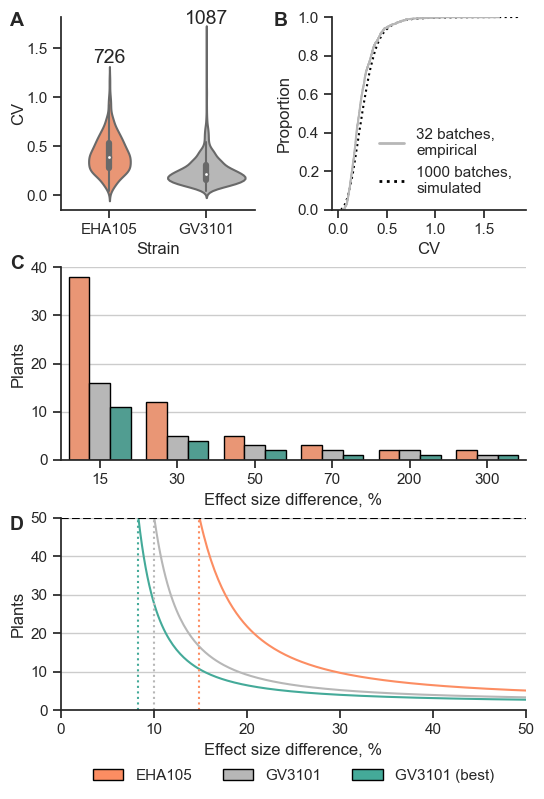

In [51]:
fig7 = plt.figure(figsize=(6, 9), constrained_layout=False)
heights = [3, 3, 3]
widths = [3, 3]
spec = gridspec.GridSpec(nrows=3, ncols=2, figure=fig7, height_ratios=heights, width_ratios=widths, wspace=0.4, hspace=0.3)
lmh_palette = [sns.color_palette(["#FC8D62"])[0], sns.color_palette("dark:#FFFFFF", 4)[2], sns.color_palette(["#44AA99"])[0]]

fig_ax00 = fig7.add_subplot(spec[0,0])
fig_ax01 = fig7.add_subplot(spec[0,1])
fig_ax10 = fig7.add_subplot(spec[1,:])
fig_ax11 = fig7.add_subplot(spec[2,:])

#Fig. 7A
sns.violinplot(data=all_data, x='Strain', y='Plant_CV', palette=lmh_palette[:2], ax=fig_ax00).set_ylabel('CV', labelpad=0)
fig_ax00.text(0, 1.35, '726', ha='center')
fig_ax00.text(1, 1.75, '1087', ha='center')

#Fig. 7B
sns.ecdfplot(data=model_validation, x='CV', hue='Simulated', palette=[sns.color_palette("dark:#FFFFFF", 4)[2], 'black'], legend=True, ax=fig_ax01)
fig_ax01.lines[0].set_linestyle(':')

empirical_handle = lines.Line2D([], [], linewidth=2, color=sns.color_palette("dark:#FFFFFF", 4)[2], label='32 batches,\nempirical')
simulated_handle = lines.Line2D([], [], linewidth=2, color='black', linestyle=':', label='1000 batches,\nsimulated')
fig_ax01.legend(handles=[empirical_handle, simulated_handle], handlelength=1.65, loc='lower right', frameon=False)

#Fig. 7C
effect_size_bar = sns.barplot(data=effect_size_df, x='effect_size', y='min_plants_needed', hue_order=['EHA105', 'GV3101', 'GV3101 (best)'], hue='Method', palette=lmh_palette, edgecolor='black', 
                              ax=fig_ax10).set(ylim=(0,40), xlabel='Effect size difference, %', ylabel='Plants')
fig_ax10.yaxis.grid(True)
fig_ax10.legend('', frameon=False)

#Fig. 7D
eha105 = exp_decay(1.9115, -48.6043) # calculate exponential decays for each strain
gv3101 = exp_decay(1.6615, -34.1236)
best = exp_decay(1.4886, -29.2417)

fig_ax11.plot(eha105[0], eha105[1], color=lmh_palette[0]) # plot exponential decays
fig_ax11.plot(gv3101[0], gv3101[1], color=lmh_palette[1])
fig_ax11.plot(best[0], best[1], color=lmh_palette[2])

fig_ax11.axvline(x=48.6043/np.log(50/1.9115), ls=':', color=lmh_palette[0]) # plot projected detection limit of 50 plants
fig_ax11.axvline(x=34.1236/np.log(50/1.6615), ls=':', color=lmh_palette[1])
fig_ax11.axvline(x=29.2417/np.log(50/1.4886), ls=':', color=lmh_palette[2])
fig_ax11.axhline(y=50, ls='--', color='black')

fig_ax11.set_xlabel('Effect size difference, %')
fig_ax11.set_ylabel('Plants')
fig_ax11.set(xlim=(0,50), xticks=range(0,55,10))
fig_ax11.set(ylim=(0,50))
fig_ax11.yaxis.grid(True)

#Add condition legend
handles = []
for strain in ['EHA105', 'GV3101', 'GV3101 (best)']:
    patch = mpatches.Patch(facecolor=lmh_palette[['EHA105', 'GV3101', 'GV3101 (best)'].index(strain)], edgecolor='black', label=strain)
    handles = handles + [patch]
plt.legend(handles=handles, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.45), frameon=False)

fig7.text(0.04, 0.87, 'A', fontdict={'weight':'bold'})
fig7.text(0.48, 0.87, 'B', fontdict={'weight':'bold'})
fig7.text(0.04, 0.60, 'C', fontdict={'weight':'bold'})
fig7.text(0.04, 0.31, 'D', fontdict={'weight':'bold'})

fig7.savefig('../03-figures/figure7.svg', format='svg', bbox_inches='tight')

In [48]:
print(48.6043/np.log(50/1.9115))
print(34.1236/np.log(50/1.6615))
print(29.2417/np.log(50/1.4886))

14.890408638565102
10.023669471506897
8.321042855251568


WATER LEVEL EXPERIMENT<br>
Plants were co-infiltrated with pVS1(spec)_PCM2:eGFP and pVS1(spec)_PCM2:mCherry at OD=0.1 each, for a total OD=0.2.<br>
Discs were measured when floated upon 340ul water in a 96-well plate. 10ul was removed from each well and measured again until the volume decreased to 260ul.<br>
8 plants/condition, 2 leaves/plant, 4 punches/leaf. 

In [49]:
#Additional function to read plate data was needed due to alternative leaf disc placement pattern in the 96-well plate.
#Discs are assumed to be filled by column, top to bottom. One plant per column. Column 1: discs from plant 1 leaf T4, plant 1 leaf T5. Column 2: discs from plant 2 leaf T4, plant 2 leaf T5, etc.
def read_plate_data_alt1(filename, date, condsperplate):
    #Make empty DataFrame using the loaded Excel file's headers.
    df = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=0)
    
    #Iterate through all the sheets of the Excel file and populate the DataFrame.
    for i in range(0, (nconds//condsperplate)):
        temp = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=96, sheet_name=i)
        temp_1 = temp[temp['Well'].apply(lambda x: int(''.join(list(x)[1:]))) < (nplants+1)]
        temp_2 = temp[temp['Well'].apply(lambda x: int(''.join(list(x)[1:]))) > nplants]
        df = pd.concat([df, temp_1, temp_2])

    #Special treatment for partially-filled plates.
    if nconds%condsperplate != 0:
        temp = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=96, sheet_name=nconds//condsperplate)
        temp = temp[temp['Well'].apply(lambda x: int(''.join(list(x)[1:]))) < (nplants+1)]
        df = pd.concat([df, temp])
    
    #Add unique plant ID #.
    df['Plant'] = list(np.arange(1, nplants+1))*nconds*nleaves*npunches
    
    #Add T4/T5 leaf information.
    df['Leaf'] = (['T4']*nplants*npunches + ['T5']*nplants*npunches)*nconds
    
    #Rename the fluorescence wavelengths as corresponding colors. Convert to float64.
    df = df.rename(columns={488520: 'eGFP', 587615: 'mCherry'})
    df['eGFP'] = (df['eGFP']).astype('float64')
    df['mCherry'] = (df['mCherry']).astype('float64')
    
    #Add date of punching.
    df['Date'] = [date]*nconds*nplants*nleaves*npunches

    #Add log2(eGFP) and log2(mCherry) columns
    df['log2green'] = np.log2(df['eGFP'])
    df['log2red'] = np.log2(df['mCherry'])

    #Calculate ratios of red and green.
    df['eGFP/mCherry'] = (df['eGFP']/df['mCherry']).astype('float64')
    df['mCherry/eGFP'] = (df['mCherry']/df['eGFP']).astype('float64')

    return df.reset_index(drop=True)

In [50]:
#Additional function to read plate data was needed due to alternative leaf disc placement pattern in the 96-well plate.
#Discs are assumed to be filled by row, left to right. One plant per row. Row A: discs from plant 1 leaf T4, plant 1 leaf T5. Row B: discs from plant 2 leaf T4, plant 2 leaf T5, etc.
def read_plate_data_alt2(filename, date):
    #Make empty DataFrame using the loaded Excel file's headers.
    df = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=0)
    
    #Iterate through all the sheets of the Excel file and populate the DataFrame.
    for i in range(0, nconds):
        temp = pd.read_excel(filename, header=31, usecols=[1,2,3], nrows=96, sheet_name=i)
        temp['Condition'] = [conds[i]]*96
        df = pd.concat([df, temp])

    #Add unique plant ID #.
    plant_ids = []
    for cond in conds:
        for plant in range(1, nplants+1):
            plant_ids = plant_ids + [plant]*12 #label all wells from a row as plant n (even though wells 9-12 are empty)
    df['Plant'] = plant_ids
    
    #Add top/bottom leaf information.
    df['Leaf'] = (['T4']*npunches + ['T5']*npunches + ['blank']*npunches)*72
    
    #Rename the fluorescence wavelengths as corresponding colors. Convert to float64.
    df = df.rename(columns={488520: 'eGFP', 587615: 'mCherry'})
    df['eGFP'] = (df['eGFP']).astype('float64')
    df['mCherry'] = (df['mCherry']).astype('float64')
    
    #Add date of punching.
    df['Date'] = date
    
    #Calculate ratios of red and green.
    df['eGFP/mCherry'] = (df['eGFP']/df['mCherry']).astype('float64')
    df['mCherry/eGFP'] = (df['mCherry']/df['eGFP']).astype('float64')
    
    return df 

In [51]:
conds = [340, 330, 320, 310, 300, 290, 280, 270, 260] 
nconds = len(conds)
nplants = 8

df_waterlvl = read_plate_data_alt2('../01-data/240930_waterlevel.xlsx', '2024.09.30')
df_waterlvl.dropna(inplace=True)

cv_waterlvl = calc_cv(df_waterlvl)

In [52]:
waterlvl_ttest_g = all_ttest(df_waterlvl, 'Condition', 'eGFP')
waterlvl_ttest_g[~waterlvl_ttest_g.reject] #DataFrame of all groups which are NOT significantly different.

,group1,group2,stat,pval,pval_corr,reject
0,260.0,270.0,1.8578,0.0655,1.0000,False
8,270.0,280.0,1.9554,0.0527,1.0000,False
15,280.0,290.0,2.5474,0.0121,0.4340,False
21,290.0,300.0,2.6328,0.0095,0.3431,False
26,300.0,310.0,2.5222,0.0129,0.4647,False
30,310.0,320.0,2.8115,0.0057,0.2060,False
33,320.0,330.0,3.0345,0.0029,0.1054,False


In [53]:
waterlvl_ttest_gr = all_ttest(df_waterlvl, 'Condition', 'eGFP/mCherry')
waterlvl_ttest_gr[waterlvl_ttest_gr.reject] #DataFrame of all groups which ARE significantly different.

,group1,group2,stat,pval,pval_corr,reject


In [54]:
stats.pearsonr(df_waterlvl.Condition, df_waterlvl.eGFP) #correlation between water level and eGFP

PearsonRResult(statistic=-0.7366391889546567, pvalue=1.410073138663568e-99)

In [55]:
stats.pearsonr(df_waterlvl.Condition, df_waterlvl['eGFP/mCherry']) #correlation between water level and eGFP/mCherry

PearsonRResult(statistic=-0.08050145238723203, pvalue=0.0534864312225287)

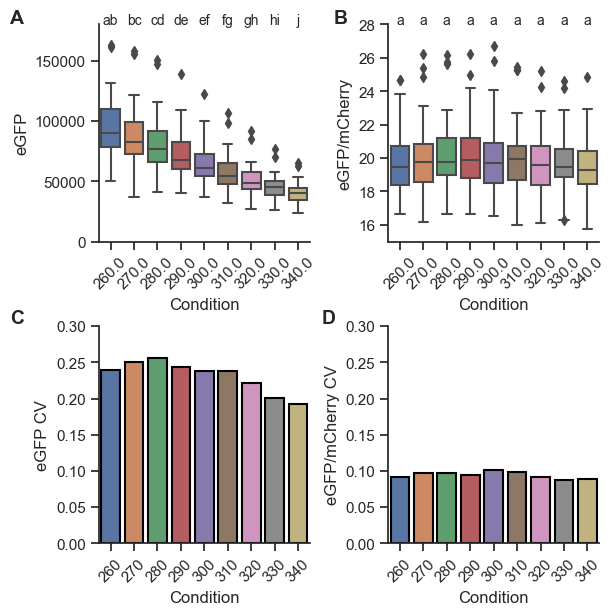

In [56]:
figS2, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(6, 6))

sns.boxplot(df_waterlvl, x='Condition', y='eGFP', ax=axs[0,0]).tick_params(axis='x', rotation=45)
axs[0,0].set_ylim(0, 180000)

sns.boxplot(df_waterlvl, x='Condition', y='eGFP/mCherry', ax=axs[0,1]).tick_params(axis='x', rotation=45)
axs[0,1].set_ylim(15, 28)

sns.barplot(cv_waterlvl, x='Condition', y='eGFP CV', edgecolor='black', linewidth=1.5, ax=axs[1,0]).set(ylim=(0, 0.3))
sns.barplot(cv_waterlvl, x='Condition', y='eGFP/mCherry CV', edgecolor='black', linewidth=1.5, ax=axs[1,1]).set(ylim=(0, 0.3))
axs[1,0].tick_params(axis='x', rotation=45)
axs[1,1].tick_params(axis='x', rotation=45)

sigchars = 'abcdefghij'
for i in list(range(nconds-1)):
    axs[0,0].text(i, 180000, sigchars[i:i+2], ha='center', fontsize=10)
    axs[0,1].text(i, 28, 'a', ha='center', fontsize=10)
axs[0,0].text(nconds-1, 180000, 'j', ha='center', fontsize=10)  
axs[0,1].text(nconds-1, 28, 'a', ha='center', fontsize=10)

figS2.text(0, 1, 'A', va='top', fontdict={'weight':'bold'})
figS2.text(0.54, 1, 'B', va='top', fontdict={'weight':'bold'})
figS2.text(0, 0.5, 'C', va='top', fontdict={'weight':'bold'})
figS2.text(0.52, 0.5, 'D', va='top', fontdict={'weight':'bold'})

figS2.savefig('../03-figures/figureS2.svg', format='svg', bbox_inches='tight')

PLANT AGE EXPERIMENT <br>
N. benthamiana plants 4 weeks old vs. 5 weeks old were compared. <br>
Plants were co-infiltrated with pVS1(spec)_PCM2:eGFP and pVS1(spec)_PCM2:mCherry at OD=0.1 each, for a total OD=0.2. <br>
8 plants/condition, 2 leaves/plant, 4 punches/leaf. 

In [60]:
nplants = 8
conds = ['4 wk']
nconds = len(conds)

df_4wk = read_plate_data_alt1('../01-data/241216_age_4wk.xlsx', '24.12.16', 2)
df_4wk['Condition'] = ['4 wk']*64
cv_4wk = calc_cv(df_4wk)

conds = ['5 wk']
nconds = len(conds)
df_5wk = read_plate_data_alt1('../01-data/241216_age_5wk.xlsx', '24.12.16', 2)
df_5wk['Condition'] = ['5 wk']*64
cv_5wk = calc_cv(df_5wk)

In [61]:
df_age = pd.concat([df_4wk, df_5wk])
cv_age = pd.concat([cv_4wk, cv_5wk])

In [62]:
stats.ttest_ind(df_4wk.eGFP, df_5wk.eGFP, False)

TtestResult(statistic=5.056067695383341, pvalue=1.4717283076886345e-06, df=126.0)

In [63]:
stats.ttest_ind(df_4wk['eGFP/mCherry'], df_5wk['eGFP/mCherry'], False)

TtestResult(statistic=16.960040313893014, pvalue=2.536493667029006e-34, df=126.0)

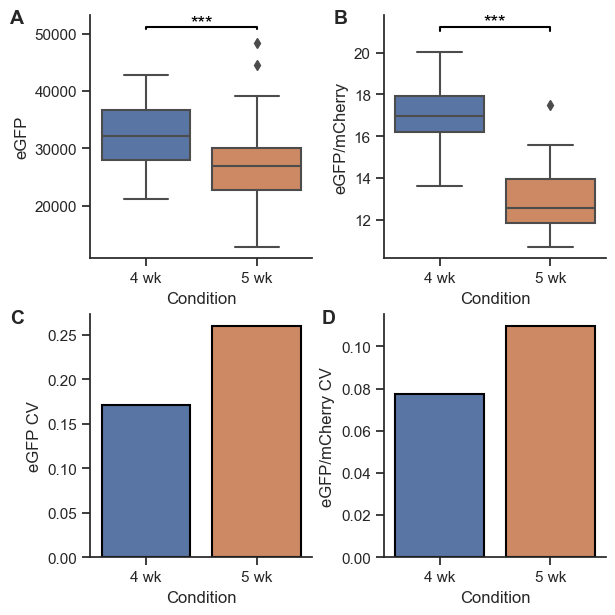

In [70]:
figS3, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(6, 6))

sns.boxplot(data=df_age, x='Condition', y='eGFP', ax=axs[0,0])
sns.boxplot(data=df_age, x='Condition', y='eGFP/mCherry', ax=axs[0,1])
sns.barplot(data=cv_age, x='Condition', y='eGFP CV', edgecolor='black', linewidth=1.5, ax=axs[1,0])
sns.barplot(data=cv_age, x='Condition', y='eGFP/mCherry CV', edgecolor='black', linewidth=1.5, ax=axs[1,1])

axs[0,0].plot([0, 0, 1, 1], [np.max(df_age.eGFP)*1.05, np.max(df_age.eGFP)*1.06, np.max(df_age.eGFP)*1.06, np.max(df_age.eGFP)*1.05], color='black')
axs[0,0].text(0.5, np.max(df_age.eGFP)*1.07, '***', color='black', va='center', ha='center')
axs[0,1].plot([0, 0, 1, 1], [np.max(df_age['eGFP/mCherry'])*1.05, np.max(df_age['eGFP/mCherry'])*1.06, np.max(df_age['eGFP/mCherry'])*1.06, np.max(df_age['eGFP/mCherry'])*1.05], color='black')
axs[0,1].text(0.5, np.max(df_age['eGFP/mCherry'])*1.07, '***', color='black', va='center', ha='center')

figS3.text(0, 1, 'A', va='top', fontdict={'weight':'bold'})
figS3.text(0.54, 1, 'B', va='top', fontdict={'weight':'bold'})
figS3.text(0, 0.5, 'C', va='top', fontdict={'weight':'bold'})
figS3.text(0.52, 0.5, 'D', va='top', fontdict={'weight':'bold'})

figS3.savefig('../03-figures/figureS3.svg', format='svg', bbox_inches='tight')

TIMELAPSE EXPERIMENT <br>
30 plants were co-infiltrated with pVS1(spec)_PCM2:eGFP and pVS1(spec)_PCM2:mCherry at OD=0.1 each, for a total OD=0.2. <br>
2 leaves/plant, 4 punches/leaf.<br>
At t=0h, 6 plants were hole-punched and measured on a plate reader. Every 2h until 8h, another 6 plants were hole-punched, and all leaf discs were measured, including those previously measured. <br>
Leaf discs were left in the 96-well plates they were measured in at room temperature for the 8h elapsed time.

In [71]:
nplants = 6

conds = ['A']
nconds = len(conds)
df_t0 = read_plate_data_alt1('../01-data/241125_timelapse0h.xlsx', '0h', 2)
df_t0['Condition'] = ['A']*48
cv_t0 = calc_cv(df_t0)
cv_t0['Date'] = ['0h']*nconds

conds = ['A', 'B']
nconds = len(conds)
df_t2 = read_plate_data_alt1('../01-data/241125_timelapse2h.xlsx', '2h', 2)
df_t2['Condition'] = ['A']*48 + ['B']*48
cv_t2 = calc_cv(df_t2)
cv_t2['Date'] = ['2h']*nconds

conds = ['A', 'B', 'C']
nconds = len(conds)
df_t4 = read_plate_data_alt1('../01-data/241125_timelapse4h.xlsx', '4h', 2)
df_t4['Condition'] = ['A']*48 + ['B']*48 + ['C']*48
cv_t4 = calc_cv(df_t4)
cv_t4['Date'] = ['4h']*nconds

conds = ['A', 'B', 'C', 'D']
nconds = len(conds)
df_t6 = read_plate_data_alt1('../01-data/241125_timelapse6h.xlsx', '6h', 2)
df_t6['Condition'] = ['A']*48 + ['B']*48 + ['C']*48 + ['D']*48
cv_t6 = calc_cv(df_t6)
cv_t6['Date'] = ['6h']*nconds

conds = ['A', 'B', 'C', 'D', 'E']
nconds = len(conds)
df_t8 = read_plate_data_alt1('../01-data/241125_timelapse8h.xlsx', '8h', 2)
df_t8['Condition'] = ['A']*48 + ['B']*48 + ['C']*48 + ['D']*48 + ['E']*48
cv_t8 = calc_cv(df_t8)
cv_t8['Date'] = ['8h']*nconds

df_timelapse = pd.concat([df_t0, df_t2, df_t4, df_t6, df_t8])

In [72]:
cv_timelapse = calc_cv(df_timelapse)
cv_timelapse_aggregate = pd.concat([cv_t0, cv_t2, cv_t4, cv_t6, cv_t8])

In [73]:
all_ttest(df_timelapse[df_timelapse.Condition == 'A'], 'Date', 'eGFP/mCherry')

,group1,group2,stat,pval,pval_corr,reject
0,0h,2h,0.7044,0.4830,1.0000,False
1,0h,4h,0.3923,0.6957,1.0000,False
2,0h,6h,1.3516,0.1798,1.0000,False
3,0h,8h,1.9276,0.0569,0.5692,False
4,2h,4h,-0.3153,0.7532,1.0000,False
5,2h,6h,0.6208,0.5362,1.0000,False
6,2h,8h,1.1752,0.2429,1.0000,False
7,4h,6h,0.9505,0.3443,1.0000,False
8,4h,8h,1.5171,0.1326,1.0000,False
9,6h,8h,0.5569,0.5789,1.0000,False


In [74]:
all_ttest(df_timelapse, 'Date', 'eGFP/mCherry')

,group1,group2,stat,pval,pval_corr,reject
0,0h,2h,0.0226,0.9820,1.0000,False
1,0h,4h,-1.2302,0.2201,1.0000,False
2,0h,6h,-0.3464,0.7293,1.0000,False
3,0h,8h,0.1941,0.8462,1.0000,False
4,2h,4h,-1.5851,0.1143,1.0000,False
5,2h,6h,-0.4818,0.6303,1.0000,False
6,2h,8h,0.2253,0.8219,1.0000,False
7,4h,6h,1.3035,0.1933,1.0000,False
8,4h,8h,2.1339,0.0335,0.3349,False
9,6h,8h,0.8815,0.3785,1.0000,False


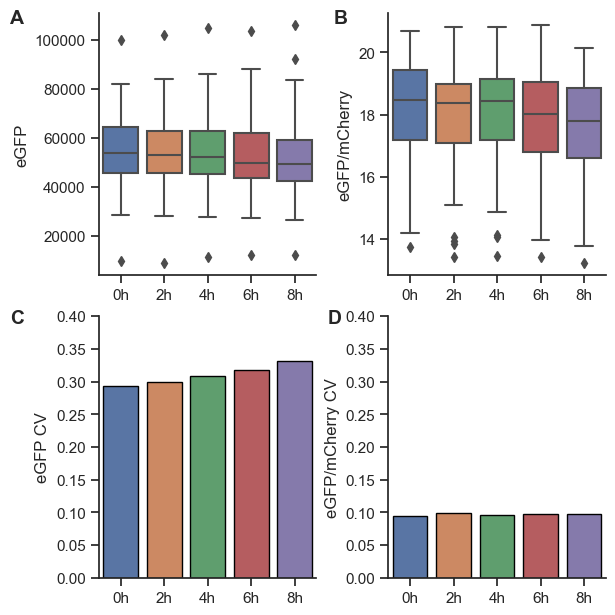

In [76]:
figS4, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(6, 6))

sns.boxplot(data=df_timelapse[df_timelapse.Condition == 'A'], x='Date', y='eGFP', ax=axs[0,0]).set(xlabel='')
sns.boxplot(data=df_timelapse[df_timelapse.Condition == 'A'], x='Date', y='eGFP/mCherry', ax=axs[0,1]).set(xlabel='')
sns.barplot(data=cv_timelapse_aggregate[cv_timelapse_aggregate.Condition == 'A'], x='Date', y='eGFP CV', ax=axs[1,0], edgecolor='black').set(xlabel='', ylim=(0, 0.4))
sns.barplot(data=cv_timelapse_aggregate[cv_timelapse_aggregate.Condition == 'A'], x='Date', y='eGFP/mCherry CV', ax=axs[1,1], edgecolor='black').set(xlabel='', ylim=(0, 0.4))

figS4.text(0, 1, 'A', va='top', fontdict={'weight':'bold'})
figS4.text(0.54, 1, 'B', va='top', fontdict={'weight':'bold'})
figS4.text(0, 0.5, 'C', va='top', fontdict={'weight':'bold'})
figS4.text(0.53, 0.5, 'D', va='top', fontdict={'weight':'bold'})

figS4.savefig('../03-figures/figureS4.svg', format='svg', bbox_inches='tight')

TIME OF DAY EXPERIMENT <br>
30 plants were co-infiltrated with pVS1(spec)_PCM2:eGFP and pVS1(spec)_PCM2:mCherry at OD=0.1 each, for a total OD=0.2. (Same data as TIMELAPSE EXPERIMENT.) <br>
2 leaves/plant, 4 punches/leaf.<br>
At t=0h/11:00am, 6 plants were hole-punched and measured on a plate reader. Every 2h until 8h/7:00pm, another 6 plants were hole-punched, and all leaf discs were measured, including those previously measured. <br>
Leaf discs were left in the 96-well plates they were measured in at room temperature for the 8h elapsed time.

In [77]:
nplants = 6

conds = ['m1'] # m# indicates the number of times the discs have been measured
nconds = len(conds)
df_t0 = read_plate_data_alt1('../01-data/241125_timelapse0h.xlsx', '11:00am', 2)
df_t0['Condition'] = ['m1']*48
cv_t0 = calc_cv(df_t0)
cv_t0['Date'] = ['11:00am']*nconds

conds = ['m2', 'm1']
nconds = len(conds)
df_t2 = read_plate_data_alt1('../01-data/241125_timelapse2h.xlsx', '1:00pm', 2)
df_t2['Condition'] = ['m2']*48 + ['m1']*48
cv_t2 = calc_cv(df_t2)
cv_t2['Date'] = ['1:00pm']*nconds

conds = ['m3', 'm2', 'm1']
nconds = len(conds)
df_t4 = read_plate_data_alt1('../01-data/241125_timelapse4h.xlsx', '3:00pm', 2)
df_t4['Condition'] = ['m3']*48 + ['m2']*48 + ['m1']*48
cv_t4 = calc_cv(df_t4)
cv_t4['Date'] = ['3:00pm']*nconds

conds = ['m4', 'm3', 'm2', 'm1']
nconds = len(conds)
df_t6 = read_plate_data_alt1('../01-data/241125_timelapse6h.xlsx', '5:00pm', 2)
df_t6['Condition'] = ['m4']*48 + ['m3']*48 + ['m2']*48 + ['m1']*48
cv_t6 = calc_cv(df_t6)
cv_t6['Date'] = ['5:00pm']*nconds

conds = ['m5', 'm4', 'm3', 'm2', 'm1']
nconds = len(conds)
df_t8 = read_plate_data_alt1('../01-data/241125_timelapse8h.xlsx', '7:00pm', 2)
df_t8['Condition'] = ['m5']*48 + ['m4']*48 + ['m3']*48 + ['m2']*48 + ['m1']*48
cv_t8 = calc_cv(df_t8)
cv_t8['Date'] = ['7:00pm']*nconds

df_timeofday = pd.concat([df_t0, df_t2, df_t4, df_t6, df_t8])

In [78]:
cv_timeofday = calc_cv(df_timeofday)
cv_timeofday_aggregate = pd.concat([cv_t0, cv_t2, cv_t4, cv_t6, cv_t8])

In [79]:
all_ttest(df_timeofday[df_timeofday.Condition == 'm1'], 'Date', 'eGFP/mCherry')

,group1,group2,stat,pval,pval_corr,reject
0,11:00am,1:00pm,-0.7182,0.4744,1.0000,False
1,11:00am,3:00pm,-2.1143,0.0371,0.3713,False
2,11:00am,5:00pm,0.0286,0.9772,1.0000,False
3,11:00am,7:00pm,-0.8464,0.3995,1.0000,False
4,1:00pm,3:00pm,-1.4716,0.1445,1.0000,False
5,1:00pm,5:00pm,0.6859,0.4945,1.0000,False
6,1:00pm,7:00pm,-0.2649,0.7917,1.0000,False
7,3:00pm,5:00pm,1.9585,0.0531,0.5314,False
8,3:00pm,7:00pm,0.9181,0.3609,1.0000,False
9,5:00pm,7:00pm,-0.8199,0.4143,1.0000,False


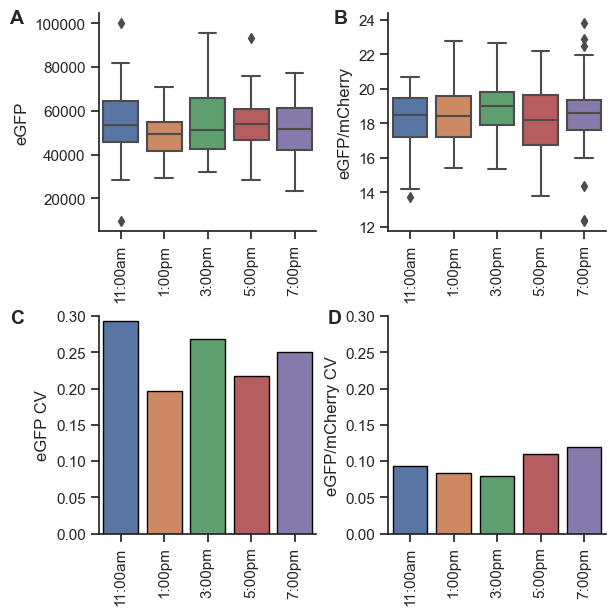

In [81]:
figS5, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(6, 6))

sns.boxplot(data=df_timeofday[df_timeofday.Condition == 'm1'], x='Date', y='eGFP', ax=axs[0,0])
sns.boxplot(data=df_timeofday[df_timeofday.Condition == 'm1'], x='Date', y='eGFP/mCherry', ax=axs[0,1])
sns.barplot(data=cv_timeofday_aggregate[cv_timeofday_aggregate.Condition == 'm1'], x='Date', y='eGFP CV', ax=axs[1,0], edgecolor='black').set(ylim=(0, 0.3))
sns.barplot(data=cv_timeofday_aggregate[cv_timeofday_aggregate.Condition == 'm1'], x='Date', y='eGFP/mCherry CV', ax=axs[1,1], edgecolor='black').set(ylim=(0, 0.3))

for i in [0,1]:
    for j in [0,1]:
        axs[i,j].tick_params(axis='x', rotation=90)
        axs[i,j].set(xlabel='')

figS5.text(0, 1, 'A', va='top', fontdict={'weight':'bold'})
figS5.text(0.54, 1, 'B', va='top', fontdict={'weight':'bold'})
figS5.text(0, 0.5, 'C', va='top', fontdict={'weight':'bold'})
figS5.text(0.53, 0.5, 'D', va='top', fontdict={'weight':'bold'})

figS5.savefig('../03-figures/figureS5.svg', format='svg', bbox_inches='tight')

C:\Users\SophiaTang\AppData\Local\Temp\ipykernel_10776\1297538891.py:86: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  figS6.savefig('../03-figures/figS6.svg', format='svg', bbox_inches='tight')
C:\Users\SophiaTang\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
C:\Users\SophiaTang\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


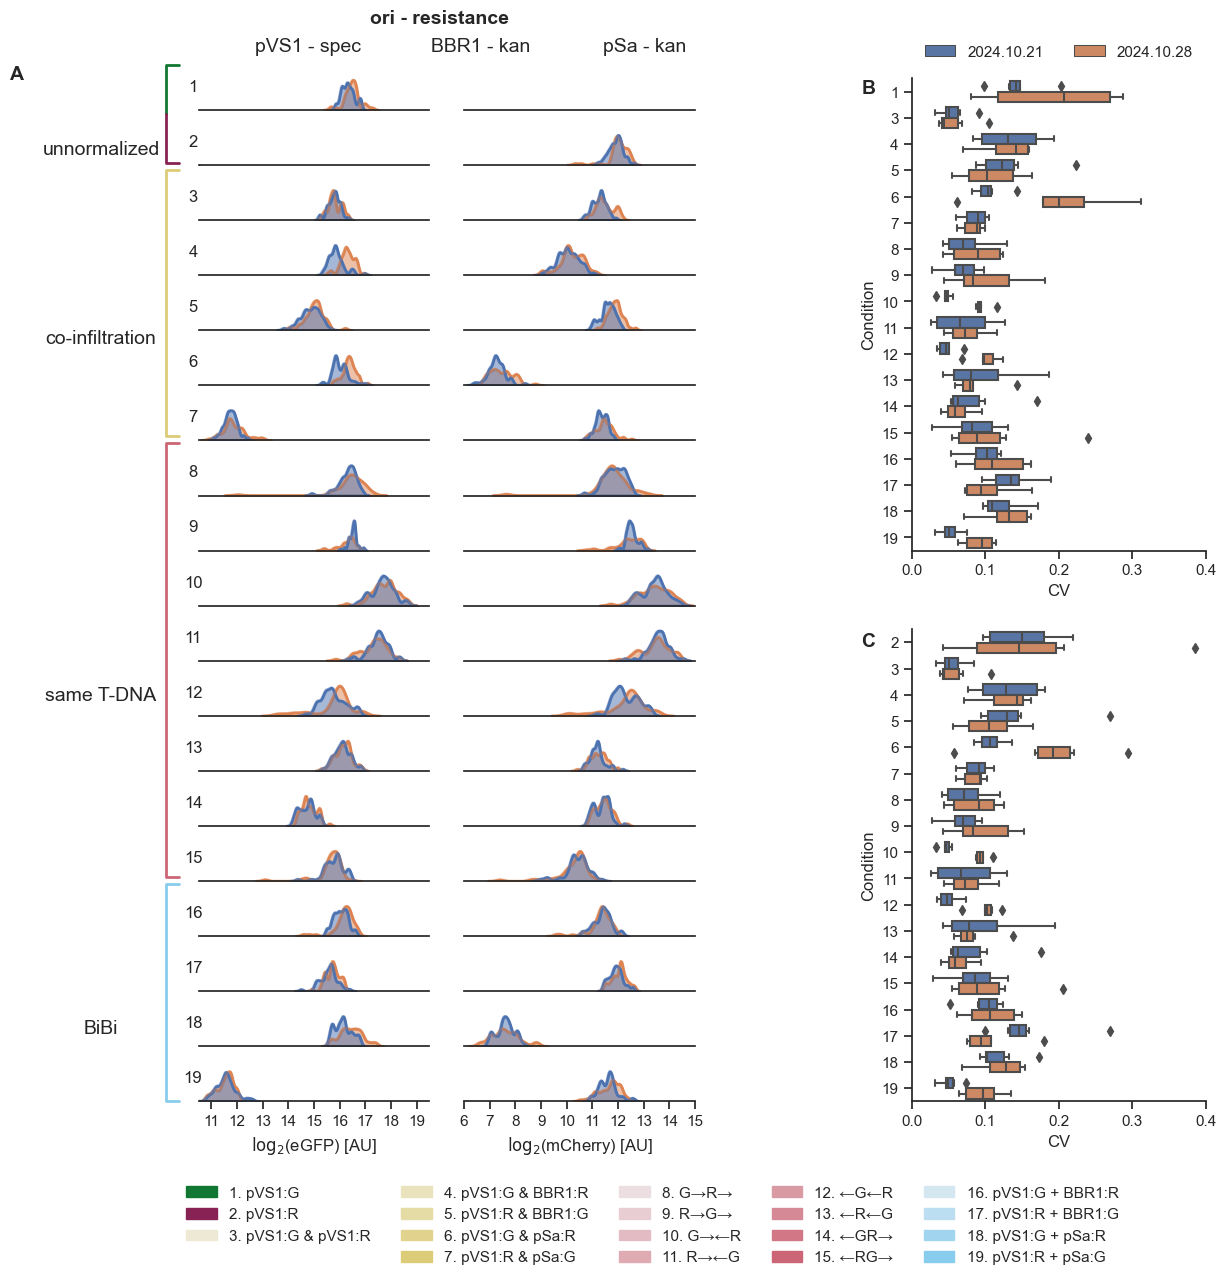

In [82]:
nplants = 6
conds = ['1. pVS1:G', '2. pVS1:R', #single strains, no normalization
         '3. pVS1:G & pVS1:R', '4. pVS1:G & BBR1:R', '5. pVS1:R & BBR1:G', '6. pVS1:G & pSa:R', '7. pVS1:R & pSa:G', #co-infiltrations
         '8. G→R→', '9. R→G→', '10. G→←R', '11. R→←G', '12. ←G←R', '13. ←R←G', '14. ←GR→', '15. ←RG→', #2 FP/T-DNA
         '16. pVS1:G + BBR1:R', '17. pVS1:R + BBR1:G', '18. pVS1:G + pSa:R', '19. pVS1:R + pSa:G'] #BiBis
nconds = len(conds)

figS6 = plt.figure(figsize=(13, 14), constrained_layout=True)
heights = [0.5]*20
widths = [3.75, 0.25, 0.25, 3.75, 3, 6]
spec = gridspec.GridSpec(ncols=6, nrows=20, figure=figS6, height_ratios=heights, width_ratios=widths, wspace=0.25, hspace=0.75)

#Define dimensions of each subplot.
axn0_list = []
axn1_list = []
for i in range(19):
    axn0 = figS6.add_subplot(spec[i+1, 0:2])
    axn1 = figS6.add_subplot(spec[i+1, 2:4])
    axn0_list.append(axn0)
    axn1_list.append(axn1)

fig_ax02 = figS6.add_subplot(spec[1:10,5])
fig_ax12 = figS6.add_subplot(spec[11:,5])

#Fig. 2A
for cond in conds:
    i = conds.index(cond)

    #left side
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2green', fill=True, ax=axn0_list[i], hue='Date', alpha=0.5, linewidth=2, bw_adjust=0.5, clip=(10.5,19.5), color=custom_palette[i], legend=False).set(xlim=(10.5, 19.5), xlabel='')
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2green', fill=False, ax=axn0_list[i], hue='Date', alpha=0.5, linewidth=2, bw_adjust=0.5, clip=(10.5,19.5), color='black', legend=False).set(xlim=(10.5, 19.5), xlabel='', ylabel=i+1)
    axn0_list[i].yaxis.label.set(rotation='horizontal')
    axn0_list[i].set_xticks([])
    axn0_list[i].set_yticks([])
    sns.despine(ax=axn0_list[i], left=True)

    #right side
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2red', fill=True, ax=axn1_list[i], hue='Date', alpha=0.5, linewidth=2, bw_adjust=0.5, clip=(6.2, 16), color=custom_palette[i], legend=False).set(xlim=(6.35, 15), xlabel='', ylabel='')
    sns.kdeplot(data=codel_df[codel_df.Condition == cond], x='log2red', fill=False, ax=axn1_list[i], hue='Date', alpha=0.5, linewidth=2, bw_adjust=0.5, clip=(6.2, 16), color='black', legend=False).set(xlim=(6.35, 15), xlabel='', ylabel='')
    axn1_list[i].set_xticks([])
    axn1_list[i].set_yticks([])
    sns.despine(ax=axn1_list[i], left=True)
    
axn0_list[len(axn0_list)-1].set_xticks(list(range(11, 20)))
axn1_list[len(axn1_list)-1].set_xticks(list(range(6, 16)))
axn0_list[len(axn0_list)-1].set_xlabel(r'$\rm{log}_{2}$(eGFP) [AU]')
axn1_list[len(axn1_list)-1].set_xlabel(r'$\rm{log}_{2}$(mCherry) [AU]')

#Fig. S6B
sns.boxplot(data=melted_green_cv, y='Condition', x='CV', hue='Date', dodge=True, orient='h', ax=fig_ax02).set(yticklabels=[1]+ list(range(3, 20)), xlim=(0,0.4))
fig_ax02.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncols=2)

#Fig. S6C
sns.boxplot(data=melted_red_cv, y='Condition', x='CV', hue='Date', dodge=True, orient='h', ax=fig_ax12).set(yticklabels=list(range(2, 20)), xlim=(0,0.4))
fig_ax12.legend('', frameon=False)

figS6.text(-0.02, 0.84, 'A', fontdict={'weight':'bold'})
figS6.text(0.635, 0.83, 'B', fontdict={'weight':'bold'})
figS6.text(0.635, 0.435, 'C', fontdict={'weight':'bold'})

figS6.text(0.31, 0.88, 'ori - resistance', fontdict={'weight':'bold'}, ha='center')
figS6.text(0.25, 0.86, 'pVS1 - spec', ha='right')
figS6.text(0.38, 0.86, 'BBR1 - kan', ha='right')
figS6.text(0.50, 0.86, 'pSa - kan', ha='right')

#Add bracket labels
figS6.text(0.05, 0.79, 'unnormalized', va='center', ha='center')
figS6.text(0.05, 0.655, 'co-infiltration', va='center', ha='center')
figS6.text(0.05, 0.4, 'same T-DNA', va='center', ha='center')
figS6.text(0.05, 0.1625, 'BiBi', va='center', ha='center')

#Add colored brackets
figS6.add_artist(lines.Line2D([0.11, 0.1, 0.1], [0.85, 0.85, 0.815], linewidth=2, color=custom_palette[0])) #green - eGFP
figS6.add_artist(lines.Line2D([0.11, 0.1, 0.1], [0.78, 0.78, 0.815], linewidth=2, color=custom_palette[1])) #magenta - mCherry
figS6.add_artist(lines.Line2D([0.11, 0.1, 0.1, 0.11], [0.775, 0.775, 0.585, 0.585], linewidth=2, color=custom_palette[6])) #yellow - co-infiltration
figS6.add_artist(lines.Line2D([0.11, 0.1, 0.1, 0.11], [0.58, 0.58, 0.27, 0.27], linewidth=2, color=custom_palette[14])) #pink - same T-DNA
figS6.add_artist(lines.Line2D([0.11, 0.1, 0.1, 0.11], [0.265, 0.265, 0.11, 0.11], linewidth=2, color=custom_palette[18])) # blue - BiBi

handles = []
for cond in conds:
    patch = mpatches.Patch(color=custom_palette[conds.index(cond)], label=cond)
    handles = handles + [patch]
handles.insert(3, mpatches.Patch(color='white', label=''))
plt.legend(handles=handles, ncol=5, bbox_to_anchor=(0.75, -0.15), frameon=False)

figS6.savefig('../03-figures/figS6.svg', format='svg', bbox_inches='tight')

In [83]:
print('Conditions for which the two weekly eGFP averages were significantly different.')
for cond in ([conds[0]] + conds [2:]):
    cond_df = codel_df[codel_df.Condition == cond]
    ttest = stats.ttest_ind(cond_df[cond_df.Date == '2024.10.21'].eGFP, cond_df[cond_df.Date == '2024.10.28'].eGFP)
    
    if ttest[1] < 0.05:
        print(cond)
        print(ttest[1])

print('\nConditions for which the two weekly mCherry averages were significantly different.')
for cond in conds[1:]:
    cond_df = codel_df[codel_df.Condition == cond]
    ttest = stats.ttest_ind(cond_df[cond_df.Date == '2024.10.21'].mCherry, cond_df[cond_df.Date == '2024.10.28'].mCherry)
    
    if ttest[1] < 0.05:
        print(cond)
        print(ttest[1])

Conditions for which the two weekly eGFP averages were significantly different.
1. pVS1:G
0.004956386975773287
4. pVS1:G & BBR1:R
1.4050847514776707e-08
5. pVS1:R & BBR1:G
0.04432656400528815
6. pVS1:G & pSa:R
5.229326137389456e-06
7. pVS1:R & pSa:G
0.036980649202041305
8. G→R→
0.026648917340454308
9. R→G→
5.480438143332505e-05
16. pVS1:G + BBR1:R
0.026379181965953173
17. pVS1:R + BBR1:G
0.03792731095776015
18. pVS1:G + pSa:R
0.00019722320664512357

Conditions for which the two weekly mCherry averages were significantly different.
3. pVS1:G & pVS1:R
0.0006687633166644821
5. pVS1:R & BBR1:G
4.141737604820718e-06
6. pVS1:G & pSa:R
0.013485651382694381
7. pVS1:R & pSa:G
0.02260185575253506
17. pVS1:R + BBR1:G
0.033132999436483804


Text(-3, 0.75, 'B')

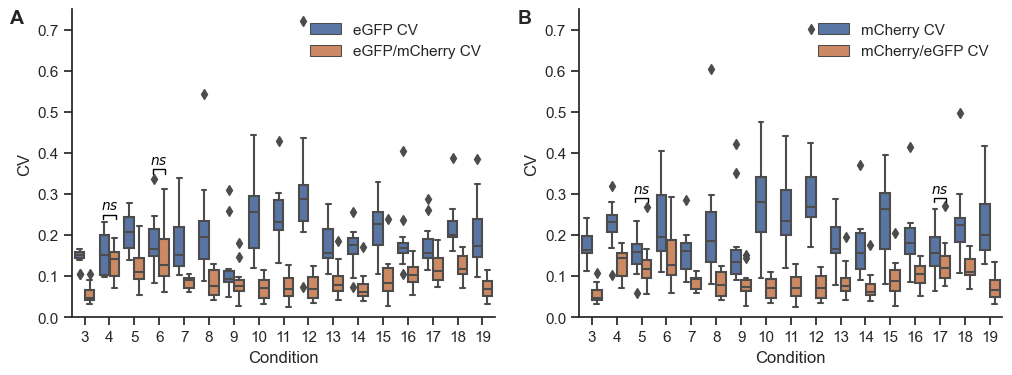

In [84]:
figS7, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

melted_green_cv = pd.melt(codel_cv_by_plant, id_vars=['Condition', 'Plant'], value_vars=['eGFP CV', 'eGFP/mCherry CV'], var_name='Statistic', value_name='CV')
sns.boxplot(data=melted_green_cv[~melted_green_cv.Condition.str.contains('|'.join(conds[:2]), case=False)], x='Condition', y='CV', hue='Statistic', ax=axs[0]).set(xticklabels=list(range(3,nconds+1)), ylim=(0, 0.75))
axs[0].add_artist(lines.Line2D([0.75, 0.75, 1.25, 1.25], [0.24, 0.25, 0.25, 0.24], linewidth=1, color='black'))
axs[0].text(1, 0.25, '$^{ns}$', color='black', ha='center')
axs[0].add_artist(lines.Line2D([2.75, 2.75, 3.25, 3.25], [0.35, 0.36, 0.36, 0.35], linewidth=1, color='black'))
axs[0].text(3, 0.36, '$^{ns}$', color='black', ha='center')
axs[0].legend(title=None, frameon=False)

melted_red_cv = pd.melt(codel_cv_by_plant, id_vars=['Condition', 'Plant'], value_vars=['mCherry CV', 'mCherry/eGFP CV'], var_name='Statistic', value_name='CV')
sns.boxplot(data=melted_red_cv[~melted_red_cv.Condition.str.contains('|'.join(conds[:2]), case=False)], x='Condition', y='CV', hue='Statistic', ax=axs[1]).set(xticklabels=list(range(3,nconds+1)), ylim=(0, 0.75))
axs[1].add_artist(lines.Line2D([1.75, 1.75, 2.25, 2.25], [0.28, 0.29, 0.29, 0.28], linewidth=1, color='black'))
axs[1].text(2, 0.29, '$^{ns}$', color='black', ha='center')
axs[1].add_artist(lines.Line2D([13.75, 13.75, 14.25, 14.25], [0.28, 0.29, 0.29, 0.28], linewidth=1, color='black'))
axs[1].text(14, 0.29, '$^{ns}$', color='black', ha='center')
axs[1].legend(title=None, frameon=False)

axs[0].text(-3, 0.75, 'A', va='top', fontdict={'weight':'bold'})
axs[1].text(-3, 0.75, 'B', va='top', fontdict={'weight':'bold'})

In [85]:
print('Conditions for which normalizing eGFP did not statistically significantly decrease CV.')
for cond in conds[2:]:
    cond_df = codel_cv_by_plant[codel_cv_by_plant.Condition == cond]
    ttest = stats.ttest_rel(cond_df['eGFP CV'], cond_df['eGFP/mCherry CV'], alternative='greater')
    if(ttest[1] > 0.05):
        print(cond)
        print(ttest[1])

print('\nConditions for which normalizing mCherry did not statistically significantly decrease CV.')
for cond in conds[2:]:
    cond_df = codel_cv_by_plant[codel_cv_by_plant.Condition == cond]
    ttest = stats.ttest_rel(cond_df['mCherry CV'], cond_df['mCherry/eGFP CV'], alternative='greater')
    if(ttest[1] > 0.05):
        print(cond)
        print(ttest[1])

Conditions for which normalizing eGFP did not statistically significantly decrease CV.
4. pVS1:G & BBR1:R
0.18361226491317584
6. pVS1:G & pSa:R
0.17730734208617294

Conditions for which normalizing mCherry did not statistically significantly decrease CV.
5. pVS1:R & BBR1:G
0.09384873380136681
17. pVS1:R + BBR1:G
0.115679778935082


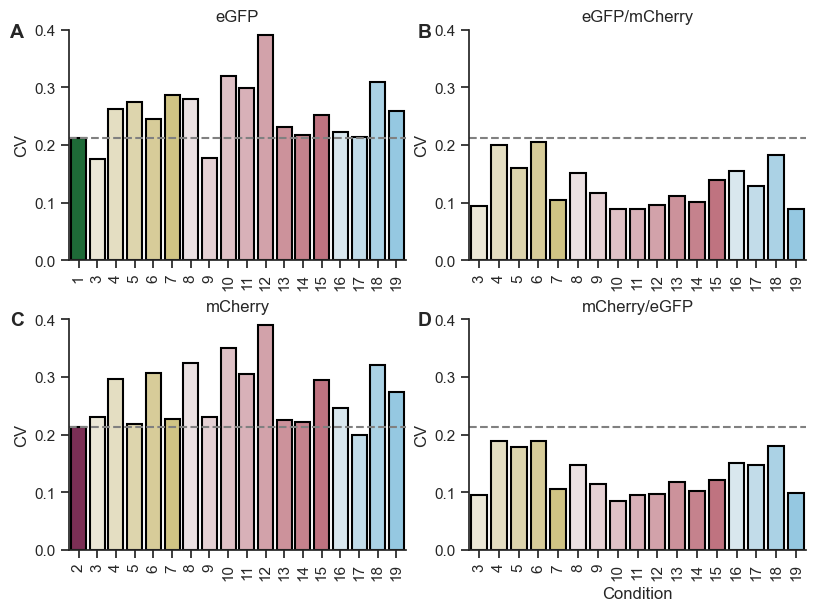

In [87]:
figS8, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 6))

#Fig. S8A
green_cv = sns.barplot(data=codel_cv[codel_cv.Condition != '2. pVS1:R'], y='eGFP CV', x='Condition', palette=([custom_palette[0]] + custom_palette[2:]), 
            edgecolor='black', linewidth=1.5, ax=axs[0,0])
green_cv.set(xticklabels=[1]+list(range(3,nconds+1)), ylim=(0, 0.4), xlabel='', ylabel='CV', title='eGFP')
axs[0,0].tick_params(axis='x', rotation=90)
axs[0,0].axhline(y=codel_cv.loc[0, 'eGFP CV'], ls='--', color='gray')

#Fig. S8B
greenred_cv = sns.barplot(data=codel_cv.iloc[2:, :], y='eGFP/mCherry CV', x='Condition', palette=custom_palette[2:], 
            edgecolor='black', linewidth=1.5, ax=axs[0,1])
greenred_cv.set(xticklabels=list(range(3,nconds+1)), ylim=(0, 0.4), xlabel='', ylabel='CV', title='eGFP/mCherry')
axs[0,1].tick_params(axis='x', rotation=90)
axs[0,1].axhline(y=codel_cv.loc[0, 'eGFP CV'], ls='--', color='gray')

#Fig. S8C
red_cv = sns.barplot(data=codel_cv[codel_cv.Condition != '1. pVS1:G'], y='mCherry CV', x='Condition', palette=custom_palette[1:], 
            edgecolor='black', linewidth=1.5, ax=axs[1,0])
red_cv.set(xticklabels=list(range(2,nconds+1)), ylim=(0, 0.4), xlabel='', ylabel='CV', title='mCherry')
axs[1,0].tick_params(axis='x', rotation=90)
axs[1,0].axhline(y=codel_cv.loc[1, 'mCherry CV'], ls='--', color='gray')

#Fig. S8D
redgreen_cv = sns.barplot(data=codel_cv.iloc[2:, :], y='mCherry/eGFP CV', x='Condition', palette=custom_palette[2:], 
            edgecolor='black', linewidth=1.5, ax=axs[1,1])
redgreen_cv.set(xticklabels=list(range(3,nconds+1)), ylim=(0, 0.4), ylabel='CV', title='mCherry/eGFP')
axs[1,1].tick_params(axis='x', rotation=90)
axs[1,1].axhline(y=codel_cv.loc[1, 'mCherry CV'], ls='--', color='gray')

figS8.text(0, 0.97, 'A', va='top', fontdict={'weight':'bold'})
figS8.text(0.51, 0.97, 'B', va='top', fontdict={'weight':'bold'})
figS8.text(0, 0.49, 'C', va='top', fontdict={'weight':'bold'})
figS8.text(0.51, 0.49, 'D', va='top', fontdict={'weight':'bold'})

figS8.savefig('../03-figures/figureS8.svg', format='svg', bbox_inches='tight')

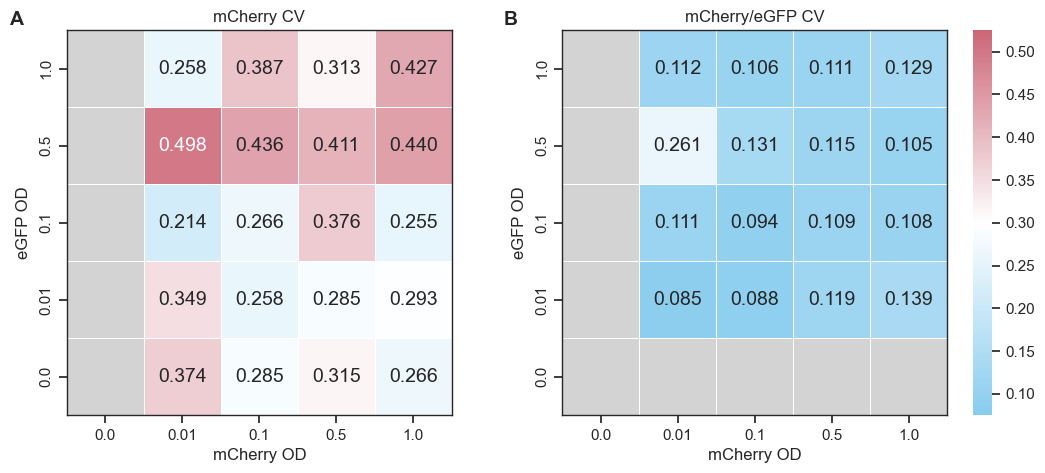

In [99]:
figS9 = plt.figure(figsize=(13,5), constrained_layout=False)
heights = [5]
widths = [4, 4, 0.2]
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=figS9, height_ratios=heights, width_ratios=widths)

#Define dimensions of each subplot.
fig_ax00 = figS9.add_subplot(spec[0,0])
fig_ax01 = figS9.add_subplot(spec[0,1:])

#Fig. S10A
od_heatmap_r = sns.heatmap(od_cv.pivot(index="eGFP OD", columns="mCherry OD", values="mCherry CV"), annot=True, cbar=False,
                         cmap=cmap, fmt=".3f", square=True, vmin=0.075, vmax=0.525, linewidth=0.5, ax=fig_ax00)
od_heatmap_r.set_ylabel('eGFP OD', labelpad=6)
od_heatmap_r.invert_yaxis()
od_heatmap_r.set(title='mCherry CV')
for _, spine in od_heatmap_r.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. S10B
od_heatmap_rg = sns.heatmap(od_cv.pivot(index="eGFP OD", columns="mCherry OD", values="mCherry/eGFP CV"), annot=True, 
                         cmap=cmap, fmt=".3f", square=True, vmin=0.075, vmax=0.525, linewidth=0.5, ax=fig_ax01)
od_heatmap_rg.set_ylabel('eGFP OD', labelpad=6)
od_heatmap_rg.invert_yaxis()
od_heatmap_rg.set(title='mCherry/eGFP CV')
for _, spine in od_heatmap_rg.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

figS9.text(0.1, 0.89, 'A', fontdict={'weight':'bold'})
figS9.text(0.48, 0.89, 'B', fontdict={'weight':'bold'})

figS9.savefig('../03-figures/figureS9.svg', format='svg', bbox_inches='tight')

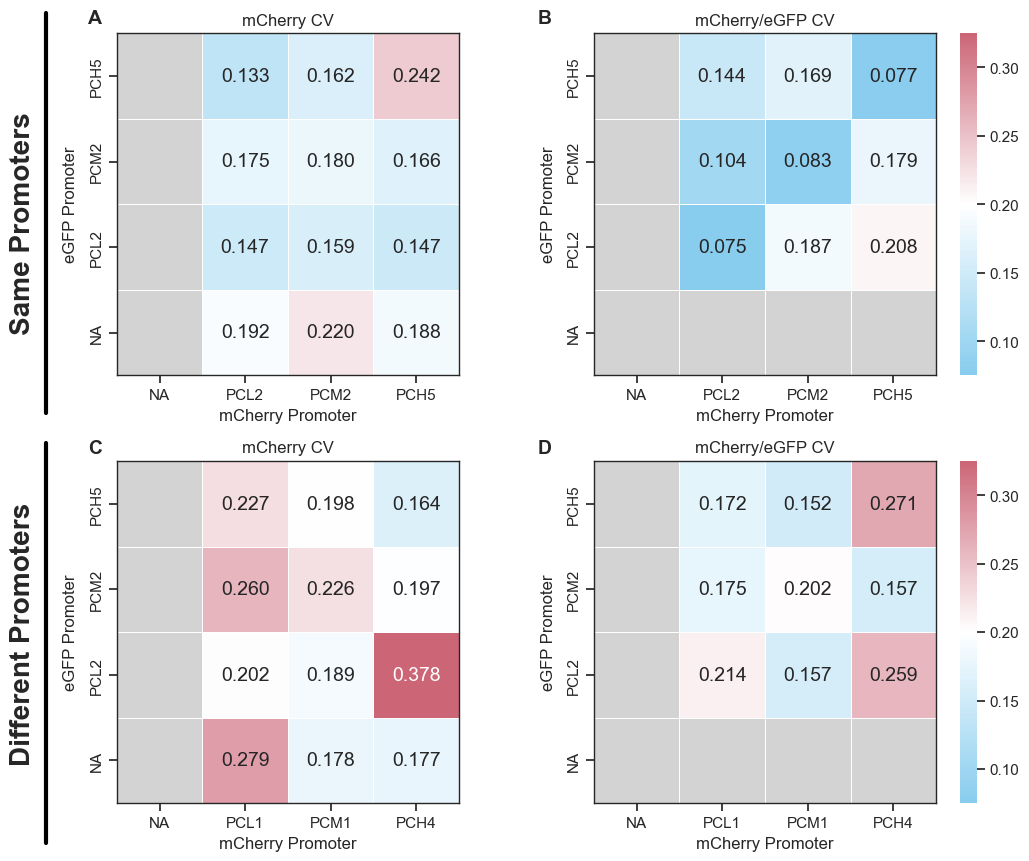

In [90]:
figS10 = plt.figure(figsize=(12, 10), constrained_layout=False)
heights = [6, 6]
widths = [4, 5]

spec = gridspec.GridSpec(ncols=2, nrows=2, figure=figS10, height_ratios=heights, width_ratios=widths, hspace=0.25)

fig_ax00 = figS10.add_subplot(spec[0,0])
fig_ax01 = figS10.add_subplot(spec[0,1])
fig_ax10 = figS10.add_subplot(spec[1,0])
fig_ax11 = figS10.add_subplot(spec[1,1])

#Fig. S11A 
pr_same_heatmap_r = sns.heatmap(data=same_matrices[1], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, cbar=False, ax=fig_ax00)
pr_same_heatmap_r.set_ylabel('eGFP Promoter', labelpad=8)
pr_same_heatmap_r.set_xlabel('mCherry Promoter')
pr_same_heatmap_r.set(title='mCherry CV')
for _, spine in pr_same_heatmap_r.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. S11B 
pr_same_heatmap_rg = sns.heatmap(data=same_matrices[3], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, ax=fig_ax01)
pr_same_heatmap_rg.set_ylabel('eGFP Promoter', labelpad=8)
pr_same_heatmap_rg.set_xlabel('mCherry Promoter')
pr_same_heatmap_rg.set(title='mCherry/eGFP CV')
for _, spine in pr_same_heatmap_rg.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. S11C 
pr_diff_heatmap_r = sns.heatmap(data=diff_matrices[1], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, cbar=False, ax=fig_ax10)
pr_diff_heatmap_r.set_ylabel('eGFP Promoter', labelpad=8)
pr_diff_heatmap_r.set_xlabel('mCherry Promoter')
pr_diff_heatmap_r.set(title='mCherry CV')
for _, spine in pr_diff_heatmap_r.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

#Fig. S11D
pr_diff_heatmap_rg = sns.heatmap(data=diff_matrices[3], cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, vmin=0.075, vmax=0.325, square=True, ax=fig_ax11)
pr_diff_heatmap_rg.set_ylabel('eGFP Promoter', labelpad=8)
pr_diff_heatmap_rg.set_xlabel('mCherry Promoter')
pr_diff_heatmap_rg.set(title='mCherry/eGFP CV')
for _, spine in pr_diff_heatmap_rg.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1) 

figS10.text(0.115, 0.89, 'A', fontdict={'weight':'bold'})
figS10.text(0.49, 0.89, 'B', fontdict={'weight':'bold'})
figS10.text(0.115, 0.46, 'C', fontdict={'weight':'bold'})
figS10.text(0.49, 0.46, 'D', fontdict={'weight':'bold'})

figS10.text(0.05, 0.69, 'Same Promoters', size='x-large', fontdict={'weight':'bold'}, va='center', rotation='vertical')
figS10.text(0.05, 0.28, 'Different Promoters', size='x-large', fontdict={'weight':'bold'}, va='center', rotation='vertical')
figS10.add_artist(lines.Line2D([0.08, 0.08], [0.90, 0.50], linewidth=3, color='black'))
figS10.add_artist(lines.Line2D([0.08, 0.08], [0.07, 0.47], linewidth=3, color='black'))

figS10.savefig('../03-figures/figureS10.svg', format='svg', bbox_inches='tight')

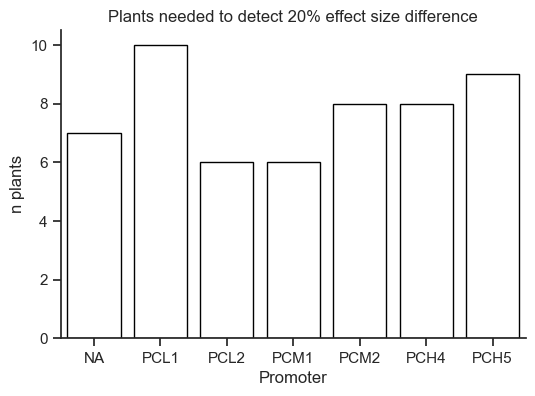

In [98]:
effect20_bycv = pd.read_csv('../01-data/effect_20_summary.csv')
effect20_bycv.loc[6, 'Promoter'] = 'NA'

figS11 = sns.barplot(data=effect20_bycv, x='Promoter', y='total_plant_number', color='white', order=['NA', 'PCL1', 'PCL2', 'PCM1', 'PCM2', 'PCH4', 'PCH5'],
           edgecolor='black').set(ylabel='n plants', title='Plants needed to detect 20% effect size difference')

plt.savefig('../03-figures/figureS11.svg', format='svg', bbox_inches='tight')

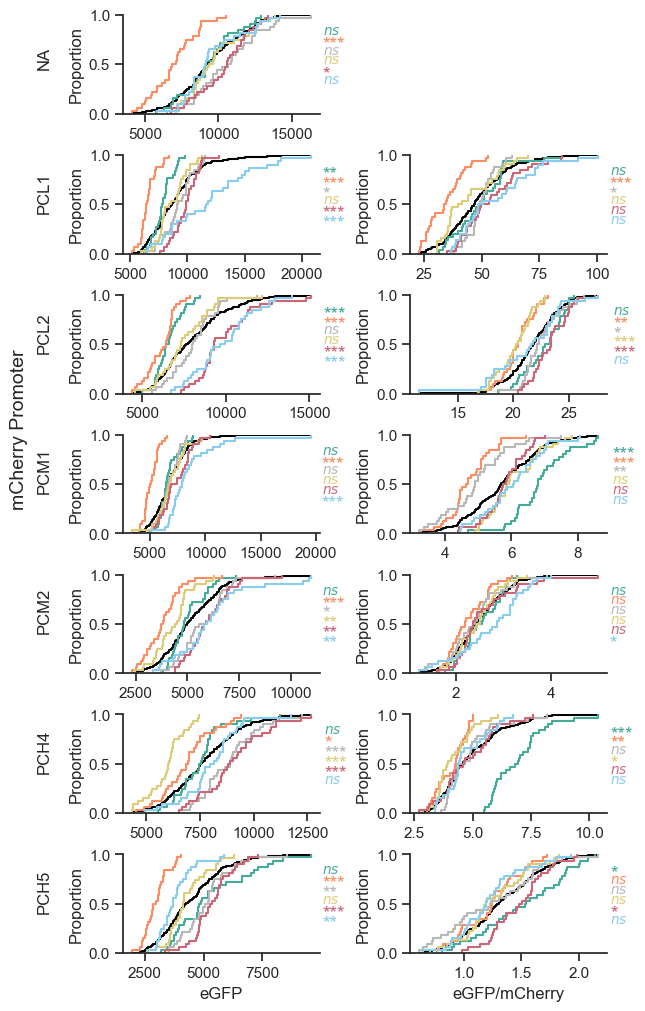

In [40]:
figS12, axs = plt.subplots(nrows=7, ncols=2, figsize=(6, 10), constrained_layout=True)
sns.despine(bottom = False, left = False)

#Plot the cdf for the PCL2:G - NA condition, which has no meaningful green/red.
rpr_df = df[df['mCherry Promoter'] == 'NA']
sns.ecdfplot(data=rpr_df, x='eGFP', ax=axs[0,0], color='black')
axs[0,0].set_title('NA', rotation='vertical', x=-0.4, y=0.4)
for date in list(df.Date.unique()):
    sns.ecdfplot(data=rpr_df[rpr_df['Date'] == date], x='eGFP', color=palette[list(df.Date.unique()).index(date)], ax=axs[0,0])

#Add Kolmogorov-Smirnov test significance symbols. 
sig_g_cond = ks_results_g[ks_results_g['mCherry Promoter'] == 'NA']
for date in list(df.Date.unique()):
    axs[0,0].text(np.max(rpr_df['eGFP'])*1.05, (0.75-0.1*list(df.Date.unique()).index(date)), sig_char(sig_g_cond[sig_g_cond['Date'] == date].index[0], 'pval', ks_results_g), fontsize=14, color=palette[list(df.Date.unique()).index(date)])
axs[0,0].set_xlabel('')
axs[0,1].axis('off')

rpr_subset = ['PCL1', 'PCL2', 'PCM1', 'PCM2', 'PCH4', 'PCH5']
for rpr in rpr_subset:
    rpr_df = df[df['mCherry Promoter'] == rpr]

    #Plot the global data for a condition (black line).
    sns.ecdfplot(data=rpr_df, x='eGFP', ax=axs[rpr_subset.index(rpr)+1, 0], color='black')
    axs[rpr_subset.index(rpr)+1, 0].set_title(rpr, rotation='vertical', x=-0.4, y=0.35)
    sns.ecdfplot(data=rpr_df, x='eGFP/mCherry', ax=axs[rpr_subset.index(rpr)+1, 1], color='black')

    sig_g_cond = ks_results_g[ks_results_g['mCherry Promoter'] == rpr]
    sig_gr_cond = ks_results_gr[ks_results_gr['mCherry Promoter'] == rpr]

    #Plot the week-by-week data for a condition.
    for date in list(df.Date.unique()):
        #Plot the green cdf. 
        sns.ecdfplot(data=rpr_df[rpr_df['Date'] == date], x='eGFP', color=palette[list(df.Date.unique()).index(date)], ax=axs[rpr_subset.index(rpr)+1, 0])
        axs[rpr_subset.index(rpr)+1, 0].text(np.max(df[df['mCherry Promoter'] == rpr]['eGFP'])*1.05, (0.75-0.1*list(df.Date.unique()).index(date)), sig_char(sig_g_cond[sig_g_cond['Date'] == date].index[0], 'pval', ks_results_g), fontsize=14, color=palette[list(df.Date.unique()).index(date)])

        #Plot the green/red cdf. 
        sns.ecdfplot(data=rpr_df[rpr_df['Date'] == date], x='eGFP/mCherry', color=palette[list(df.Date.unique()).index(date)], ax=axs[rpr_subset.index(rpr)+1, 1])
        axs[rpr_subset.index(rpr)+1, 1].text(np.max(df[df['mCherry Promoter'] == rpr]['eGFP/mCherry'])*1.05, (0.75-0.1*list(df.Date.unique()).index(date)), sig_char(sig_gr_cond[sig_gr_cond['Date'] == date].index[0], 'pval', ks_results_gr), fontsize=14, color=palette[list(df.Date.unique()).index(date)])
    
    axs[rpr_subset.index(rpr)+1, 0].set_xlabel('')
    axs[rpr_subset.index(rpr)+1, 1].set_xlabel('')

axs[6,0].set_xlabel('eGFP')
axs[6,1].set_xlabel('eGFP/mCherry')
figS12.text(-0.05, 0.5, 'mCherry Promoter', rotation=90)

figS12.savefig('../03-figures/figureS12.svg', format='svg', bbox_inches='tight')